# UDACITY -- Self-Driving Car Engineer [NanoDegree] --
# Part-1--Project-04 - **ADVANCED LANE FINDING**  &
# Part-1--Project-05 - **VEHICLE DETECTION AND TRACKING**

### PLEASE NOTE:  
I have **Combined Both Projects** in a **Single IPython NoteBook** as they are **Related**.

**Part-1--Project-04 - ADVANCED LANE FINDING**  
Is First Below.

For  
**Part-1--Project-05 - VEHICLE DETECTION AND TRACKING**  
Please Scroll Down **[CELL-13 Onwards]**. Thanks!

# UDACITY -- Self-Driving Car Engineer [NanoDegree] --
# Part-1--Project-04 - **ADVANCED LANE FINDING**

## GOALS/STEPS OF THE PROJECT
1. Camera Calibration.
2. Image Distortion Correction.
3. Image Color & Gradient Thresholding.
4. Image Perspective Transform.
5. Detect Lane Lines.
6. Determine the Lane Curvature & Relative Position of Vehicle in the Lane.


## IMPORT PROJECT DEPENDENCIES

In [ ]:
### IMPORT PROJECT DEPENDENCIES
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib qt

## 1. CAMERA CALIBRATION

### Step 1: Define ObjectPoints & Extract ImagePoints For Camera Calibration

In [ ]:
### PARAMETERS
# CHESSBOARD PATTERN Used For CALIBRATION
# NUMBER Of CORNERS In CHESSBOARD PATTERN Used: 6 x 9 (ny x nx)
nx = 9 # Number of Inside Corners in x.
ny = 6 # Number of Inside Corners in y.

### Arrays To Store Actually Detected Object Points & Image Points
### From All The Calibration Images
object_points_detected = [] # 3-D Points In Real-World Space.
image_points_detected  = [] # 2-D Points In Image Plane.

### REAL-WORLD ACTUAL CHESSBOARD PATTERN -- OBJECT POINTS
# Prepare Object Points - Like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
object_points       = np.zeros((ny*nx,3), np.float32)
object_points[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### CAMERA IMAGES OF CHESSBOARD PATTERN -- IMAGE POINTS
# Make a List of Calibration Images
images_calib = glob.glob('./Camera_Cal/calibration*.jpg')
# Step Through The List and Search For ChessBoard Corners
for idx, fname in enumerate(images_calib):
    # Read the Image File & Convert To GrayScale
    img      = cv2.imread(fname)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the ChessBoard Corners
    ret, corners = cv2.findChessboardCorners(img_gray, (nx,ny), None)
    
    # If Corners are Successfully Found,
    # Then Add corresponding Object Points & Image Points To Detection Arrays
    if (True == ret):
        object_points_detected.append(object_points)
        image_points_detected.append(corners)
        
        # Draw and Display the Detected Corners
        print("OK!: CHESSBOARD CORNERS Found In: ", fname)
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('Detected Corners', img)
        cv2.waitKey(1000)
        
        # Optional Step: Save the Corners Detected Image For Later Analysis
        #write_file_name = 'corners_'+fname+'.jpg'
        #cv2.imwrite(write_file_name, img)
    else:
        print("ERROR!: CHESSBOARD CORNERS Not Found In: ", fname)

cv2.destroyAllWindows() # Close the Detection Images Display.


### Step 2: Calibrate Camera
**1. Calc Camera Matrix & Distortion Co-efficients**  
**2. Test UnDistortion**  
**3. Save Camera Calibration Data For Later Use**

In [ ]:
### Read-In a Test Image
image      = cv2.imread('./Camera_Cal/calibration3.jpg')
image_size = (image.shape[1], image.shape[0]) # img.shape[1::-1]

### 1. Calc Camera Matrix & Distortion Co-efficients
# Do Camera Calibration, Given Object Points & Image Points
retval, matrix, distort_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points_detected, 
                                                                  image_points_detected, 
                                                                  image_size, None, None)
print()
print("cv2.calibrateCamera() retval: ", retval)
print()

### 2. Test UnDistortion
if (retval > 0): # NOTE!: retval of cv2.calibrateCamera() was 1.186...! So (True == retval) WON'T WORK!!!
    image_undistorted = cv2.undistort(image, matrix, distort_coeff, None, matrix)
    cv2.imwrite('./Camera_Cal/undistorted_calibration3.jpg',image_undistorted)
else:
    assert False, ("ERROR!: Check For Error In cv2.calibrateCamera()")

### 3. Save CAMERA CALIBRATION DATA For Later Use [We Ignore `rvecs` & `tvecs`]
cam_cal_pickle = {}
cam_cal_pickle["matrix"]        = matrix
cam_cal_pickle["distort_coeff"] = distort_coeff
pickle.dump(cam_cal_pickle, open("./Camera_Cal/cam_cal_pickle.p", "wb"))
print()
print("OK!: CAMERA CALIBRATED & CAMERA CALIBRATION DATA SAVED!")
print()

### VISUALIZE UNDISTORTION
#cv2.imshow('UnDistorted Image', image_undistorted)
#image_undistorted = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('UnDistorted Image', fontsize=30)


### Additional Step: UnWarp the UnDistorted Image & Check
### FUNCTION To UNWARP an Input IMAGE of UNDISTORTED ChessBoard Pattern CORNERS and Return the UnWarped Image
def image_corners_unwarp(image_undistorted, nx, ny):
    ### 1) Convert To GrayScale
    image_gray = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2GRAY)
    
    ### 2) Find the ChessBoard Corners
    ret, corners = cv2.findChessboardCorners(image_gray, (nx,ny), None)
    
    ### 3) If Corners Found, UnWarp the Image, using the following Steps:
         # a) Draw the Corners.
         # b) Define 4 Source Points src = np.float32([[,],[,],[,],[,]]).
         #    NOTE: Pick Any 4 of the Detected Corners as long as they Define a Rectangle.
         #          One especially Smart Way to do this is to Use 4 Well-chosen Corners
         #          that were Automatically Detected by cv2 in the ChessBoard Pattern.
         # c) Define 4 Destination Points dest = np.float32([[,],[,],[,],[,]]).
         # d) Use cv2.getPerspectiveTransform() To Get M, the Transformation Matrix.
         # e) Use cv2.warpPerspective() To UnWarp the Image To a Perfect Top-Down View.
    if (True == ret):
        image_corners = cv2.drawChessboardCorners(image_undistorted, (nx,ny), corners, ret)
    else:
        assert False, ("ERROR!: Check For Error In cv2.findChessboardCorners()")
    
    # For Analysis
    #print()
    #print("Corners[]:")
    #print(corners)
    #print()
                                       # Corners[i] -> [[x y]]; Corners[i][0] -> [x y].
                                       # NOTE!: np.float32() Below!
    src_corner_left_top     = np.float32(corners[0])    # Index: Min x, Min y.
    src_corner_right_top    = np.float32(corners[nx-1]) # Index: Max x, Min y; Index of x is From 0,...
    src_corner_right_bottom = np.float32(corners[-1])   # Index: Max x, Max y; Last Entry Of 'corners[]'.
    src_corner_left_bottom  = np.float32(corners[-nx])  # Index: Min x, Max y; -1 -> Last x, -nx -> First x.
    print()
    print("src_corner_left_top     : ", src_corner_left_top)
    print("src_corner_right_top    : ", src_corner_right_top)
    print("src_corner_right_bottom : ", src_corner_right_bottom)
    print("src_corner_left_bottom  : ", src_corner_left_bottom)
    print()
    
    img_size_x = image_corners.shape[1]
    img_size_y = image_corners.shape[0]
    offset     = np.float32((image_corners.shape[1]/nx) / 2) # Length of 1/2 Square -> Offset From (0,0) To 1st Corner.
    dest_corner_left_top     = np.float32([offset, offset])
    dest_corner_right_top    = np.float32([img_size_x-offset, offset])
    dest_corner_right_bottom = np.float32([img_size_x-offset, img_size_y-offset])
    dest_corner_left_bottom  = np.float32([offset, img_size_y-offset])
    print()
    print("dest_corner_left_top     : ", dest_corner_left_top)
    print("dest_corner_right_top    : ", dest_corner_right_top)
    print("dest_corner_right_bottom : ", dest_corner_right_bottom)
    print("dest_corner_left_bottom  : ", dest_corner_left_bottom)
    print()
    
    src_points  = np.float32([ src_corner_left_top  , src_corner_right_top  , src_corner_right_bottom  , src_corner_left_bottom  ])
    dest_points = np.float32([ dest_corner_left_top , dest_corner_right_top , dest_corner_right_bottom , dest_corner_left_bottom ])
    
    M              = cv2.getPerspectiveTransform(src_points, dest_points)
    image_unwarped = cv2.warpPerspective(image_undistorted, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    ### OUTPUT Of image_corners_unwarp(image_undistorted, nx, ny)
    return image_unwarped


### CALL FUNCTION image_corners_unwarp(image_undistorted, nx, ny)
image_unwarped = image_corners_unwarp(image_undistorted, nx, ny)

### VISUALIZE UNWARP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_undistorted)
ax1.set_title('UnDistorted Image', fontsize=30)
ax2.imshow(image_unwarped)
ax2.set_title('UnWarped Image', fontsize=30)


## 2. IMAGE DISTORTION CORRECTION (UNDISTORT)

In [ ]:
### Read-In the Saved CAMERA CALIBRATION DATA
cam_cal_pickle = pickle.load(open("./Camera_Cal/cam_cal_pickle.p", "rb"))
matrix         = cam_cal_pickle["matrix"]
distort_coeff  = cam_cal_pickle["distort_coeff"]

### FUNCTION To UNDISTORT an Input IMAGE and Return the UnDistorted Image
def image_undistort(image_in):
    ### UnDistort the Input Image
    image_undistorted = cv2.undistort(image_in, matrix, distort_coeff, None, matrix)
    
    ### OUTPUT Of image_undistort(image_in)
    return image_undistorted


### Read-In a Test Image
fpath    = './Test_Images/'
fname    = 'test5.jpg'
image_in = mpimg.imread(fpath+fname)

### CALL FUNCTION image_undistort(image_in) and See the Output
image_undistorted = image_undistort(image_in)
cv2.imwrite(fpath+'UnDistorted_'+fname, image_undistorted)

### VISUALIZE UNDISTORTION
#cv2.imshow('UnDistorted Image', image_undistorted)
#image_undistorted = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_in)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('UnDistorted Image', fontsize=30)


## 3. IMAGE COLOR & GRADIENT THRESHOLDING [TO ENABLE LANE LINES DETECTION]

In [ ]:
### FUNCTION To Calculate SOBEL x or y
def sobel_xory(img, orient='x', sobel_kernel=3):
    ### Applying the following Steps to `img`:
    ### 1) Convert To GrayScale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # We Use `cv2.COLOR_RGB2GRAY` as we have Read the Image through `mpimg.imread()`.
    ### 2) Take the Derivative in x or y given `orient` = 'x' or 'y'
    if ('x' == orient):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif ('y' == orient):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        assert False, ("Value of Parameter 'orient' is INVALID!")
    ### 3) RETURN SOBEL x or y
    return sobel


### FUNCTION To Calculate SOBEL x and y
def sobel_xy(img, sobel_kernel=3):
    ### Applying the following Steps to `img`:
    ### 1) Convert To GrayScale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # We Use `cv2.COLOR_RGB2GRAY` as we have Read the Image through `mpimg.imread()`.
    ### 2) Take the Gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    ### 3) RETURN SOBEL x and y
    return sobel_x, sobel_y


### FUNCTION that Takes-In SOBEL x or y, Calculates ABSOLUTE Value, and Applies a THRESHOLD
def sobel_xory_abs_threshold(sobel_xory, sobel_thresh=(0, 255)):
    ### Applying the following Steps to `sobel_xory`:
    ### 1) Take the Absolute Value of the Derivative/Gradient
    sobel_abs = np.absolute(sobel_xory)
    ### 2) Scale To 8-bit (0 - 255), then Convert To Type = `np.uint8`
    sobel_scaled = np.uint8((255/np.max(sobel_abs))*sobel_abs)
    ### 3) Create a Mask of 1's where the Scaled Gradient Magnitude
    ###    is >= `thresh_min` and <= `thresh_max`
    sobel_binary = np.zeros_like(sobel_scaled)
    sobel_binary[(sobel_scaled >= sobel_thresh[0]) & (sobel_scaled <= sobel_thresh[1])] = 1
    ### 4) RETURN the SOBEL BINARY IMAGE
    return sobel_binary


### FUNCTION that Takes-In SOBEL x and y, Computes the Overall MAGNITUDE of the Gradient, and Applies a THRESHOLD
def sobel_xy_mag_threshold(sobel_x, sobel_y, sobel_mag_thresh=(0, 255)):
    ### Applying the following Steps to `sobel_x` and `sobel_y`:
    ### 1) Calculate the Overall Magnitude
    sobel_xy_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    ### 2) Scale To 8-bit (0 - 255), and Convert To Type = `np.uint8`
    sobel_xy_scaled = np.uint8((255/np.max(sobel_xy_mag))*sobel_xy_mag)
    ### 3) Create a Binary Mask of 1's where `sobel_mag_thresh` are met
    sobel_xy_binary = np.zeros_like(sobel_xy_scaled)
    sobel_xy_binary[(sobel_xy_scaled >= sobel_mag_thresh[0]) & (sobel_xy_scaled <= sobel_mag_thresh[1])] = 1
    ### 4) RETURN the SOBEL BINARY IMAGE
    return sobel_xy_binary


### FUNCTION that Takes-In SOBEL x and y, Computes the Overall DIRECTION of the Gradient, and Applies a THRESHOLD
def sobel_xy_dir_threshold(sobel_x, sobel_y, sobel_dir_thresh=(0, np.pi/2)):
    ### Applying the following Steps to `sobel_x` and `sobel_y`:
    ### 1) Take the Absolute Value of the Sobel x and y Gradients
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    ### 2) Use `np.arctan2(sobel_y_abs, sobel_x_abs)` to Calculate the Direction of the Gradient
    sobel_xy_dir = np.arctan2(sobel_y_abs, sobel_x_abs)
    ### 3) Create a Binary Mask of 1's where `sobel_dir_thresh` are met
    sobel_xy_binary = np.zeros_like(sobel_xy_dir)
    sobel_xy_binary[(sobel_xy_dir >= sobel_dir_thresh[0]) & (sobel_xy_dir <= sobel_dir_thresh[1])] = 1
    ### 4) RETURN the SOBEL BINARY IMAGE
    return sobel_xy_binary


### FUNCTION that Takes-In an RGB Image, Converts it To HLS, and THRESHOLDs the S-Channel of HLS
### Using Exclusive Lower Bound (>) and Inclusive Upper Bound (<=)
def hls_s_threshold(img, hls_s_thresh=(0, 255)):
    ### 1) Convert To HLS Color Space and Separate S-Channel
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # We Use `cv2.COLOR_RGB2HLS` as we have Read the Image through `mpimg.imread()`.
    S = img_hls[:,:,2]
    ### 2) Apply Threshold To the S-Channel
    hls_s_binary = np.zeros_like(S)
    hls_s_binary[(S > hls_s_thresh[0]) & (S <= hls_s_thresh[1])] = 1
    ### 3) RETURN the THRESHOLDED BINARY IMAGE
    return hls_s_binary


### FUNCTION that Takes-In an RGB Image, Converts it To HLS, and THRESHOLDs the H-Channel of HLS
### Using Exclusive Lower Bound (>) and Inclusive Upper Bound (<=)
def hls_h_threshold(img, hls_h_thresh=(0, 255)):
    ### 1) Convert To HLS Color Space and Separate H-Channel
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # We Use `cv2.COLOR_RGB2HLS` as we have Read the Image through `mpimg.imread()`.
    H = img_hls[:,:,0]
    ### 2) Apply Threshold To the H-Channel
    hls_h_binary = np.zeros_like(H)
    hls_h_binary[(H > hls_h_thresh[0]) & (H <= hls_h_thresh[1])] = 1
    ### 3) RETURN the THRESHOLDED BINARY IMAGE
    return hls_h_binary


### FUNCTION that Takes-In an RGB Image, Converts it To HLS, and THRESHOLDs Both the S-Channel & H-Channel of HLS
### Using Exclusive Lower Bound (>) and Inclusive Upper Bound (<=)
def hls_sh_threshold(img, hls_s_thresh=(0, 255), hls_h_thresh=(0, 255)):
    ### 1) Convert To HLS Color Space and Separate S-Channel & H-Channel
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # We Use `cv2.COLOR_RGB2HLS` as we have Read the Image through `mpimg.imread()`.
    S = img_hls[:,:,2]
    H = img_hls[:,:,0]
    ### 2) Apply Thresholds To the S-Channel & H-Channel
    hls_sh_binary = np.zeros_like(S)
    hls_sh_binary[( ((S > hls_s_thresh[0]) & (S <= hls_s_thresh[1])) & ((H > hls_h_thresh[0]) & (H <= hls_h_thresh[1])) )] = 1
    ### 3) RETURN the THRESHOLDED BINARY IMAGE
    return hls_sh_binary


######### PIPELINE - PROCESS LANES - Combined COLOR AND GRADIENT THRESHOLDING #########
# REFERENCE: sobel_thresh=(20, 100), hls_s_thresh=(170, 255)
def pipeline_lanes_color_and_grad_threshold(image_rgb):
    ### Take the RGB R-Channel, Apply Different Sobels, Then Apply the Corresponding Threshold
    R = image_rgb[:,:,0]
    image_rgb_r = np.dstack(( R, np.zeros_like(R), np.zeros_like(R) )) # R, G=0, B=0.
    # image_rgb_r = image_rgb

    rgb_r_sobel_x = sobel_xory(image_rgb_r, orient='x', sobel_kernel=7)
    rgb_r_sobel_y = sobel_xory(image_rgb_r, orient='y', sobel_kernel=7)
    rgb_r_sobel_x_abs_binary  = sobel_xory_abs_threshold(rgb_r_sobel_x, sobel_thresh=(24, 120))
    rgb_r_sobel_y_abs_binary  = sobel_xory_abs_threshold(rgb_r_sobel_y, sobel_thresh=(24, 120))
    rgb_r_sobel_xy_mag_binary = sobel_xy_mag_threshold(rgb_r_sobel_x, rgb_r_sobel_y, sobel_mag_thresh=(32, 128))
    rgb_r_sobel_xy_dir_binary = sobel_xy_dir_threshold(rgb_r_sobel_x, rgb_r_sobel_y, sobel_dir_thresh=(0.7, 1.2))

    rgb_r_sobel_combined = np.zeros_like(R)
    rgb_r_sobel_combined[((rgb_r_sobel_x_abs_binary == 1))] = 1
    # rgb_r_sobel_combined[((rgb_r_sobel_x_abs_binary == 1) & (rgb_r_sobel_y_abs_binary == 1))] = 1
    # rgb_r_sobel_combined[((rgb_r_sobel_xy_mag_binary == 1))] = 1
    # rgb_r_sobel_combined[((rgb_r_sobel_xy_mag_binary == 1) & (rgb_r_sobel_xy_dir_binary == 1))] = 1
    # rgb_r_sobel_combined[((rgb_r_sobel_x_abs_binary == 1) & (rgb_r_sobel_y_abs_binary == 1)) | ((rgb_r_sobel_xy_mag_binary == 1) & (rgb_r_sobel_xy_dir_binary == 1))] = 1

    ### HLS Thresholding
    """
    ## HLS S Thresholding
    hls_s_thresh_bin = hls_s_threshold(image_rgb, hls_s_thresh=(160, 255))
    ## HLS H Thresholding
    hls_h_thresh_bin = hls_h_threshold(image_rgb, hls_h_thresh=(16, 96))
    ## Combine HLS Thresholding
    hls_thresh_bin = np.zeros_like(R)
    # hls_thresh_bin[((hls_s_thresh_bin == 1))] = 1
    hls_thresh_bin[((hls_s_thresh_bin == 1) & (hls_h_thresh_bin == 1))] = 1
    """
    ## HLS S&H Thresholding
    hls_thresh_bin = hls_sh_threshold(image_rgb, hls_s_thresh=(160, 255), hls_h_thresh=(16, 96))

    ### RGB R Direct Thresholding - Especially To Get Fillings Inside White Line Segments' Boundaries!
    rgb_r_thresh=(224,255)
    rgb_r_binary = np.zeros_like(R)
    rgb_r_binary[(R >= rgb_r_thresh[0]) & (R <= rgb_r_thresh[1])] = 1

    ### Stack Each Output For Viewing
    # lanes_proc_pipeline_view = np.dstack(( rgb_r_sobel_combined, np.zeros_like(R), hls_thresh_bin )) * 255 # R=RGB-R_Gradient, G=0, B=HLS.
    lanes_proc_pipeline_view = np.dstack(( rgb_r_binary, rgb_r_sobel_combined, hls_thresh_bin )) * 255 # R=RGB-R, G=RGB-R_Gradient, B=HLS.

    ### PREPARE OUTPUT Of LANE LINES PROCESSING
    lanes_proc_output = np.zeros_like(R)
    # lanes_proc_output[(rgb_r_sobel_combined == 1) | (hls_thresh_bin == 1)] = 1
    lanes_proc_output[(rgb_r_binary == 1) | (rgb_r_sobel_combined == 1) | (hls_thresh_bin == 1)] = 1

    ### OUTPUT Of pipeline_lanes_color_and_grad_threshold(image_rgb)
    return lanes_proc_output, lanes_proc_pipeline_view


### CALL the PIPELINE To PROCESS LANE LINES On the Earlier `image_undistorted` and See the Output
adv_lane_lines, lanes_proc_pipeline_view = pipeline_lanes_color_and_grad_threshold(image_undistorted)

### VISUALIZE The RESULTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(lanes_proc_pipeline_view)
ax1.set_title('Lane Processing Stack View', fontsize=40)
ax2.imshow(adv_lane_lines, cmap='gray')
ax2.set_title('Final Lane Lines On UnDistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## 4. IMAGE PERSPECTIVE TRANSFORM [TO ENABLE LANE LINES DETECTION]

In [ ]:
### FUNCTION To COMPUTE PERSPECTIVE TRANSFORM & INVERSE PERSPECTIVE TRANSFORM MATRICES
### NOTE!: The PARAMETERS BELOW Are For The GIVEN CAM & IMAGE RES [720x1280] In This PROJECT!
M    = [] # GLOBAL VAR!: PERSPECTIVE TRANSFORM MATRIX.
Minv = [] # GLOBAL VAR!: INVERSE PERSPECTIVE TRANSFORM MATRIX.
def compute_perspective_transform_matrices():
    ### Compute The Perspective Transform Matrices using the following Steps:
      # a) Define 4 Source Points src = np.float32([[,],[,],[,],[,]]).
      # b) Define 4 Destination Points dest = np.float32([[,],[,],[,],[,]]).
      #    NOTE: From './Test_Images/straight_lines1.jpg' &
      #               './Test_Images/straight_lines2.jpg',
      #          UNDISTORTED & Chose 4 Points [Average] Which Would Form A Perfect Rectangle
      #          In Ego-Lane In Top-Down View:
      #    -------------------------------------------------------------------------------
      #     straight_lines1.jpg | straight_lines2.jpg | Src Pts Average | Destination Pts
      #    -------------------------------------------------------------------------------
      #       582, 460          |   579, 460          |   581, 460      |   267,   0
      #       702, 460          |   705, 460          |   704, 460      |  1042,   0
      #      1040, 680          |  1044, 680          |  1042, 680      |  1042, 680
      #       264, 680          |   270, 680          |   267, 680      |   267, 680
      #    -------------------------------------------------------------------------------
      # c) Use cv2.getPerspectiveTransform() To Get M, the Transformation Matrix.
      # d) Use cv2.warpPerspective() To UnWarp the Image To a Perfect Top-Down View.
    src_point_left_top     = np.float32([ 581, 460])
    src_point_right_top    = np.float32([ 704, 460])
    src_point_right_bottom = np.float32([1042, 680])
    src_point_left_bottom  = np.float32([ 267, 680])
    print()
    print("src_point_left_top     : ", src_point_left_top)
    print("src_point_right_top    : ", src_point_right_top)
    print("src_point_right_bottom : ", src_point_right_bottom)
    print("src_point_left_bottom  : ", src_point_left_bottom)
    print()
    
    dest_point_left_top     = np.float32([ 267,   0])
    dest_point_right_top    = np.float32([1042,   0])
    dest_point_right_bottom = np.float32([1042, 680])
    dest_point_left_bottom  = np.float32([ 267, 680])
    print()
    print("dest_point_left_top     : ", dest_point_left_top)
    print("dest_point_right_top    : ", dest_point_right_top)
    print("dest_point_right_bottom : ", dest_point_right_bottom)
    print("dest_point_left_bottom  : ", dest_point_left_bottom)
    print()
    
    src_points  = np.float32([ src_point_left_top  , src_point_right_top  , src_point_right_bottom  , src_point_left_bottom  ])
    dest_points = np.float32([ dest_point_left_top , dest_point_right_top , dest_point_right_bottom , dest_point_left_bottom ])
    
    M    = cv2.getPerspectiveTransform(src_points, dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points, src_points)
    
    ### OUTPUT Of compute_perspective_transform_matrices()
    return M, Minv

### CALL FUNCTION compute_perspective_transform_matrices()
### To COMPUTE & STORE PERSPECTIVE TRANSFORM MATRICES
M, Minv = compute_perspective_transform_matrices()
print()
print("OK!: PERSPECTIVE TRANSFORM & INVERSE PERSPECTIVE TRANSFORM MATRICES")
print("     FOR VIEWING LANES IN BIRD's-EYE VIEW ARE CALCULATED & STORED!")
print()


### FUNCTION To UNWARP an Input UNDISTORTED IMAGE Of LANES and Return the UnWarped Image
def lanes_image_unwarp(image_undistorted):
    image_unwarped = cv2.warpPerspective(image_undistorted, M, image_undistorted.shape[1::-1], flags=cv2.INTER_LINEAR)
    ### OUTPUT Of lanes_image_unwarp(image_undistorted)
    return image_unwarped


### CALL FUNCTION lanes_image_unwarp(image_undistorted)
# image_unwarped_binary = lanes_image_unwarp(image_undistorted)
image_unwarped_binary = lanes_image_unwarp(adv_lane_lines)
image_unwarped_file = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary))*255
cv2.imwrite(fpath+'UnWarped_'+fname, image_unwarped_file)

### VISUALIZE UNWARP
## Draw The Reference Points Onto The Source & Destination Images
adv_lane_lines_visual = np.dstack((adv_lane_lines, adv_lane_lines, adv_lane_lines))*255
src_pts = np.array([[581,460],[704,460],[1042,680],[267,680]], np.int32)
src_pts = src_pts.reshape((-1,1,2))
cv2.polylines(adv_lane_lines_visual,[src_pts],True,(255,0,0),thickness=6) # RED Color Lines.

image_unwarped_visual = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary))*255
dest_pts = np.array([[267,0],[1042,0],[1042,680],[267,680]], np.int32)
dest_pts = dest_pts.reshape((-1,1,2))
cv2.polylines(image_unwarped_visual,[dest_pts],True,(255,0,0),thickness=6) # RED Color Lines.

## Visualize The Images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.imshow(image_undistorted)
#ax1.set_title('UnDistorted Image', fontsize=30)
#ax1.imshow(adv_lane_lines, cmap='gray')
ax1.imshow(adv_lane_lines_visual)
ax1.set_title('Color & Gradient Thresholded Image', fontsize=30)
#ax2.imshow(image_unwarped_binary, cmap='gray')
ax2.imshow(image_unwarped_visual)
ax2.set_title('ROI UnWarped Image', fontsize=30)


## 5. DETECT LANE LINES [SLIDING WINDOWS & SEARCH FROM PRIOR]

In [ ]:
######### PIPELINE - FIND LANE LINES - DETECTION FUNCTIONS #########
### FEATURE SWITCHES
SWITCH_lanes_find_lines_VISUALIZATION   = True # Default = `True` Here.
SWITCH_search_around_poly_VISUALIZATION = True # Default = `True` Here.


### FUNCTION To Calc Histogram Of Image Pixels And FIND LANE LINES Using Sliding Windows
def lanes_find_lines(image_unwarped_binary):
    ### For Input - 'UnWarped Binary Image' of Lanes, Calculate a Histogram of the Bottom Half of the Image
    lanes_histogram  = np.sum(image_unwarped_binary[image_unwarped_binary.shape[0]//2:,:], axis=0)
    if (True == SWITCH_lanes_find_lines_VISUALIZATION):
        plt.plot(lanes_histogram)
        plt.title('Lanes Histogram', fontsize=20)
        plt.show()

    ### Split the Histogram Vertically For the 2 Lane Lines
    ### And Find the Peak of the Left & Right Halves of the Histogram -> Starting Points for the Left & Right Lane Lines
    img_midpoint     = np.int(lanes_histogram.shape[0]//2)
    left_peak_xbase  = np.argmax(lanes_histogram[:img_midpoint])
    right_peak_xbase = np.argmax(lanes_histogram[img_midpoint:]) + img_midpoint

    ### Set-up the Sliding Windows and Windows' HyperParameters
    ## HYPERPARAMETERS
    # Choose the Number of Sliding Windows
    num_windows = 9
    # Set the Width of the Windows +/- Margin
    window_margin = 100
    # Set the Height of the Windows - Based On Image Shape & `num_windows`
    window_height = np.int(image_unwarped_binary.shape[0]//num_windows)
    # Current Positions of the Windows - To Be Updated Later For Each Window in `num_windows` and Use For Tracking
    left_peak_xcurrent   = left_peak_xbase
    right_peak_xcurrent  = right_peak_xbase
    # Set the Minimum Number of Pixels If Found Will Recenter a Window
    windows_recenter_minpix = 50
    # Identify the x and y Positions of All Non-Zero (i.e., Actual Activated) Pixels in the 'UnWarped Binary Image'
    img_pixels_nonzero   = image_unwarped_binary.nonzero()
    img_pixels_nonzero_y = np.array(img_pixels_nonzero[0])
    img_pixels_nonzero_x = np.array(img_pixels_nonzero[1])
    # Create Empty Lists To Receive Left & Rigt Lane Pixel Indices Falling Within the Windows
    left_lane_pixels_indxs  = []
    right_lane_pixels_indxs = []
    ### Create an Output Image to Draw On & Visualize the Result
    if (True == SWITCH_lanes_find_lines_VISUALIZATION):
        # image_out = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary))*255
        image_out = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary))

    ### Iterate Through `num_windows` To Track Lane Curvature
    for window in range(num_windows): # Loop Through Each Window in `num_windows`.
        # 1) Find the Boundaries of the Current Window in x and y [And Left & Right]
        #    Based On `left_peak_xcurrent`, `right_peak_xcurrent`, as well as `window_margin`
        window_y_bottom = image_unwarped_binary.shape[0] - ((window+1) * window_height)
        # window_y_top  = image_unwarped_binary.shape[0] - (window * window_height)
        window_y_top    = window_y_bottom + window_height
        window_xleft_low   = left_peak_xcurrent  - window_margin
        window_xleft_high  = left_peak_xcurrent  + window_margin
        window_xright_low  = right_peak_xcurrent - window_margin
        window_xright_high = right_peak_xcurrent + window_margin
        
        # 2) Draw the Window Boundaries Onto the Visualization Image `image_out`
        if (True == SWITCH_lanes_find_lines_VISUALIZATION):
            cv2.rectangle(image_out, (window_xleft_low, window_y_bottom), 
                          (window_xleft_high, window_y_top), (0,255,0), 3) # Green Color Window.
            cv2.rectangle(image_out, (window_xright_low,window_y_bottom), 
                          (window_xright_high,window_y_top), (0,255,0), 3) # Green Color Window.
        
        # 3) Find Which Activated Pixels From `img_pixels_nonzero_y` and `img_pixels_nonzero_x` Actually Fall Into the Window
        #    and Append These Pixels To the Lists `left_lane_pixels_indxs[]` and `right_lane_pixels_indxs[]`
        good_l_lane_pixels_indxs = ( (img_pixels_nonzero_y >= window_y_bottom) & (img_pixels_nonzero_y < window_y_top) & 
            (img_pixels_nonzero_x >= window_xleft_low ) & (img_pixels_nonzero_x < window_xleft_high ) ).nonzero()[0]
        good_r_lane_pixels_indxs = ( (img_pixels_nonzero_y >= window_y_bottom) & (img_pixels_nonzero_y < window_y_top) & 
            (img_pixels_nonzero_x >= window_xright_low) & (img_pixels_nonzero_x < window_xright_high) ).nonzero()[0]
        left_lane_pixels_indxs.append( good_l_lane_pixels_indxs)
        right_lane_pixels_indxs.append(good_r_lane_pixels_indxs)
        
        # 4) If the Number of Pixels Found In Previous Step > `windows_recenter_minpix`, Then RE-CENTER NEXT WINDOW ONWARDS,
        #    i.e., Update `left_peak_xcurrent` and `right_peak_xcurrent` Based On Mean Position Of These Pixels
        if len(good_l_lane_pixels_indxs) > windows_recenter_minpix:
            left_peak_xcurrent  = np.int(np.mean(img_pixels_nonzero_x[good_l_lane_pixels_indxs]))
        if len(good_r_lane_pixels_indxs) > windows_recenter_minpix:
            right_peak_xcurrent = np.int(np.mean(img_pixels_nonzero_x[good_r_lane_pixels_indxs]))

    ### OUTPUT PREPARATION
    # Concatenate the Arrays of Indices (Previously Was A List Of Lists Of Pixels)
    try:
        left_lane_pixels_indxs  = np.concatenate(left_lane_pixels_indxs)
        right_lane_pixels_indxs = np.concatenate(right_lane_pixels_indxs)
    except ValueError:
        print("Error In Finding left_lane_pixels_indxs, right_lane_pixels_indxs!!!")
        pass
    # Extract Left & Right Lane Line Pixel Positions
    left_lane_pixels_x  = img_pixels_nonzero_x[left_lane_pixels_indxs]
    left_lane_pixels_y  = img_pixels_nonzero_y[left_lane_pixels_indxs]
    right_lane_pixels_x = img_pixels_nonzero_x[right_lane_pixels_indxs]
    right_lane_pixels_y = img_pixels_nonzero_y[right_lane_pixels_indxs]

    ### OUTPUT Of lanes_find_lines(image_unwarped_binary)
    if (True == SWITCH_lanes_find_lines_VISUALIZATION):
        return left_lane_pixels_x, left_lane_pixels_y, right_lane_pixels_x, right_lane_pixels_y, image_out
    else:
        return left_lane_pixels_x, left_lane_pixels_y, right_lane_pixels_x, right_lane_pixels_y


### FUNCTION To FIT POLYNOMIAL To The LANE LINE PIXELS
def lanes_pixels_fit_polynomial(image_shape, left_lane_pixels_x, left_lane_pixels_y, right_lane_pixels_x, right_lane_pixels_y):
    ### Fit a 2nd Order POLYNOMIAL For Left & Right Lane Lines -
    ### Using `np.polyfit()` To Generate `left_line_fit` and `right_line_fit`
    left_line_fit  = np.polyfit(left_lane_pixels_y,  left_lane_pixels_x,  2)
    right_line_fit = np.polyfit(right_lane_pixels_y, right_lane_pixels_x, 2)

    ### Generate x and y Values For Plotting
    plot_y = np.linspace(0, image_shape[0]-1, image_shape[0])
    # Calc Points From Both POLYNOMIALs Using `plot_y`, `left_line_fit` and `right_line_fit`
    try:
        left_line_fit_x  = (left_line_fit[0]  * (plot_y**2)) + (left_line_fit[1]  * plot_y) + left_line_fit[2]
        right_line_fit_x = (right_line_fit[0] * (plot_y**2)) + (right_line_fit[1] * plot_y) + right_line_fit[2]
    except TypeError:
        print("Error In Fitting Lane Line(s)!!!")
        left_line_fit_x  = 1*plot_y**2 + 1*plot_y
        right_line_fit_x = 1*plot_y**2 + 1*plot_y

    ### OUTPUT Of lanes_pixels_fit_polynomial(image_shape, left_lane_pixels_x, left_lane_pixels_y, right_lane_pixels_x, right_lane_pixels_y)
    return left_line_fit, right_line_fit, left_line_fit_x, right_line_fit_x, plot_y


### FUNCTION To VISUALIZE FIT POLYNOMIAL To The LANE LINE PIXELS
def lanes_fit_polynomial_visualize(image_out, 
                                   left_lane_pixels_x, left_lane_pixels_y, 
                                   right_lane_pixels_x, right_lane_pixels_y, 
                                   left_line_fit_x, right_line_fit_x, plot_y):
    ### Color-in Left & Right Lane Line Pixels
    image_out[left_lane_pixels_y,  left_lane_pixels_x]  = [255, 0,   0] # RGB-R.
    image_out[right_lane_pixels_y, right_lane_pixels_x] = [  0, 0, 255] # RGB-B.
    if (True == SWITCH_lanes_find_lines_VISUALIZATION):
        ### Plots the Left & Right Polynomials On the Lane Lines
        plt.plot(left_line_fit_x,  plot_y, color='yellow')
        plt.plot(right_line_fit_x, plot_y, color='yellow')
        ### VISUALIZATION
        plt.imshow(image_out)
        plt.title('Lanes - Sliding Windows & Polynomial', fontsize=20)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    ### OUTPUT Of lanes_fit_polynomial_visualize()
    return image_out


### FUNCTION To Use the Previously Fit POLYNOMIAL To SERACH AROUND, Skipping The Sliding Window
def search_around_poly(image_unwarped_binary, left_line_fit, right_line_fit):
    ### HYPERPARAMETER
    # Choose the Width of the Margin Around the Previous POLYNOMIAL To Search
    poly_margin = 100

    ### Grab the x and y Positions of All Activated Pixels From Current Frame
    img_pixels_nonzero   = image_unwarped_binary.nonzero()
    img_pixels_nonzero_y = np.array(img_pixels_nonzero[0])
    img_pixels_nonzero_x = np.array(img_pixels_nonzero[1])

    ### Set the Area Of Search Based On Activated X-Values Within the +/- Margin Of the POLYNOMIAL Function
    left_line_fit_x_pixels  = (left_line_fit[0]  * (img_pixels_nonzero_y**2)) + (left_line_fit[1]  * img_pixels_nonzero_y) + left_line_fit[2]
    right_line_fit_x_pixels = (right_line_fit[0] * (img_pixels_nonzero_y**2)) + (right_line_fit[1] * img_pixels_nonzero_y) + right_line_fit[2]
    left_lane_pixels_indxs  = ( (img_pixels_nonzero_x > (left_line_fit_x_pixels  - poly_margin)) & 
        (img_pixels_nonzero_x < (left_line_fit_x_pixels  + poly_margin)) )
    right_lane_pixels_indxs = ( (img_pixels_nonzero_x > (right_line_fit_x_pixels - poly_margin)) & 
        (img_pixels_nonzero_x < (right_line_fit_x_pixels + poly_margin)) )

    ### Again, Extract the Newly Found Left & Right Lanes' Pixels' Positions
    left_lane_pixels_x  = img_pixels_nonzero_x[left_lane_pixels_indxs]
    left_lane_pixels_y  = img_pixels_nonzero_y[left_lane_pixels_indxs]
    right_lane_pixels_x = img_pixels_nonzero_x[right_lane_pixels_indxs]
    right_lane_pixels_y = img_pixels_nonzero_y[right_lane_pixels_indxs]

    ### And Again, Fit a NEW POLYNOMIAL For the Newly Found Left & Right Lane Line Pixels
    left_line_fit, right_line_fit, left_line_fit_x, right_line_fit_x, plot_y = lanes_pixels_fit_polynomial(image_unwarped_binary.shape, left_lane_pixels_x, left_lane_pixels_y, right_lane_pixels_x, right_lane_pixels_y)

    ### VISUALIZATION
    if (True == SWITCH_search_around_poly_VISUALIZATION):
        ### Create an Output Image to Draw On & Visualize the Result
        ### And an Image To Show the Selection Window
        # image_out        = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary))*255
        image_out        = np.dstack((image_unwarped_binary, image_unwarped_binary, image_unwarped_binary)) # Lanes Image In RGB.
        image_sel_window = np.zeros_like(image_out)                                                         # Selection Window Blank.
        ### Color-in Left & Right Lane Line Pixels
        image_out[left_lane_pixels_y,  left_lane_pixels_x]  = [255, 0,   0] # RGB-R.
        image_out[right_lane_pixels_y, right_lane_pixels_x] = [  0, 0, 255] # RGB-B.
        ### Generate a Polygon to Illustrate the Search Window Area
        ### And Recast the x and y Points To Usable Format For `cv2.fillPoly()`
        left_line_window_left   = np.array([np.transpose(np.vstack([left_line_fit_x-poly_margin, plot_y]))])
        left_line_window_right  = np.array([np.flipud(np.transpose(np.vstack([left_line_fit_x+poly_margin, plot_y])))])
        left_line_points        = np.hstack((left_line_window_left, left_line_window_right))
        right_line_window_left  = np.array([np.transpose(np.vstack([right_line_fit_x-poly_margin, plot_y]))])
        right_line_window_right = np.array([np.flipud(np.transpose(np.vstack([right_line_fit_x+poly_margin, plot_y])))])
        right_line_points       = np.hstack((right_line_window_left, right_line_window_right))
        ### Use `cv2.fillPoly()` To Draw the 'Search Window Regions' Onto 'Selection Window Blank' Image
        cv2.fillPoly(image_sel_window, np.int_([left_line_points]),  (0,255,0)) # Green Fill Selection Window.
        cv2.fillPoly(image_sel_window, np.int_([right_line_points]), (0,255,0)) # Green Fill Selection Window.
        ### Add the 'Search Window Regions' To 'Lanes Image In RGB'
        image_out = cv2.addWeighted(image_out, 1, image_sel_window, 0.33, 0)
        ### Plot the POLYNOMIAL Lines Onto the Image
        plt.plot(left_line_fit_x,  plot_y, color='yellow')
        plt.plot(right_line_fit_x, plot_y, color='yellow')
        ### VISUALIZATION
        plt.imshow(image_out)
        plt.title('Search Around Previous Polynomial', fontsize=20)
        plt.show()

    ### OUTPUT Of search_around_poly(image_unwarped_binary, left_line_fit, right_line_fit)
    return left_line_fit, right_line_fit, left_line_fit_x, right_line_fit_x, plot_y


######### CALL The LANE LINES DETECTION FUNCTIONS And VISUALIZE Their OUTPUTS #########
### 1) CALL FUNCTION lanes_find_lines()
if (True == SWITCH_lanes_find_lines_VISUALIZATION):
    left_lane_pixels_x, left_lane_pixels_y, \
    right_lane_pixels_x, right_lane_pixels_y, image_out = lanes_find_lines(image_unwarped_binary)
else:
    left_lane_pixels_x, left_lane_pixels_y, \
    right_lane_pixels_x, right_lane_pixels_y = lanes_find_lines(image_unwarped_binary)

### 2) CALL FUNCTION lanes_pixels_fit_polynomial()
left_line_fit, right_line_fit, \
left_line_fit_x, right_line_fit_x, plot_y = lanes_pixels_fit_polynomial(image_unwarped_binary.shape, 
                                                                        left_lane_pixels_x, left_lane_pixels_y, 
                                                                        right_lane_pixels_x, right_lane_pixels_y)

### 3) CALL FUNCTION lanes_fit_polynomial_visualize()
if (True == SWITCH_lanes_find_lines_VISUALIZATION):
    image_out = lanes_fit_polynomial_visualize(image_out, 
                                               left_lane_pixels_x, left_lane_pixels_y, 
                                               right_lane_pixels_x, right_lane_pixels_y, 
                                               left_line_fit_x, right_line_fit_x, plot_y)

### 4) CALL FUNCTION search_around_poly()
left_line_fit, right_line_fit, \
left_line_fit_x, right_line_fit_x, plot_y = search_around_poly(image_unwarped_binary, 
                                                               left_line_fit, 
                                                               right_line_fit)


## 6. DETERMINE LANE CURVATURE & RELATIVE POSITION OF VEHICLE

In [ ]:
### Define Conversions In x and y From Pixels Space To Real-World Space [meters]
mx = 3.7/700 # ~Meters Per Pixel in x Dimension.
my = 30/720  # ~Meters Per Pixel in y Dimension.


### FUNCTION To MEASURE CURVATURE Of LANE LINES In REAL-WORLD DIMENSIONS [meters]
### From Corresponding Polynomial Functions
def lanes_measure_curvature_real(left_line_fit, right_line_fit, plot_y):
    ### Convert The POLYNOMIAL Fit Co-efficients From Pixel-World To Real-World [meters]
    ### NOTE!: POLYNOMIAL In Pixel-World: x = A*(y**2) + B*y + C
    ###     => POLYNOMIAL In Real-World : x = (mx/(my**2))*A*(y**2) + (mx/my)*B*y + C
    left_fit_real_A  = (mx/(my**2)) * left_line_fit[0]
    left_fit_real_B  = (mx/my)      * left_line_fit[1]
    left_fit_real_C  = left_line_fit[2]
    left_fit_real    = [left_fit_real_A, left_fit_real_B, left_fit_real_C]
    
    right_fit_real_A = (mx/(my**2)) * right_line_fit[0]
    right_fit_real_B = (mx/my)      * right_line_fit[1]
    right_fit_real_C = right_line_fit[2]
    right_fit_real   = [right_fit_real_A, right_fit_real_B, right_fit_real_C]
    
    ### Define y-Value Where We Want the Radius Of Curvature
    # We'll Choose the Maximum y-Value, Corresponding To the Bottom Of the Image (Near the Car)
    y_eval = np.max(plot_y)
    
    ### Calculation of R_Curve (Radius of Curvature) ###
    rad_curve_left_real  = ( (1 + ((2*left_fit_real[0]*y_eval*my)  + left_fit_real[1] )**2)**1.5 ) / (np.absolute(2*left_fit_real[0] ))
    rad_curve_right_real = ( (1 + ((2*right_fit_real[0]*y_eval*my) + right_fit_real[1])**2)**1.5 ) / (np.absolute(2*right_fit_real[0]))
    
    ### OUTPUT Of lanes_measure_curvature_real(left_line_fit, right_line_fit, plot_y)
    return rad_curve_left_real, rad_curve_right_real


### FUNCTION To MEASURE RELATIVE POSITION OF VEHICLE W.R.To LANE CENTER [in meters]
def vehicle_measure_lane_offset(left_line_fit, right_line_fit, plot_y):
    ### Define y-Value Where We Want the Measurement
    y_eval = np.max(plot_y) # Bottom Of the Image -> Near the Car
    
    ### Calculate The Lane Offset
    left_lane_base_x   = (left_line_fit[0]*(y_eval**2))  + (left_line_fit[1]*y_eval)  + left_line_fit[2]
    right_lane_base_x  = (right_line_fit[0]*(y_eval**2)) + (right_line_fit[1]*y_eval) + right_line_fit[2]
    lane_center_pixel  = np.int((left_lane_base_x + right_lane_base_x)/2)
    image_x_center     = np.int((image_unwarped_binary.shape[1])/2)
    lane_offset_pixels = lane_center_pixel - image_x_center
    lane_offset_real   = lane_offset_pixels*mx
    
    ### OUTPUT Of vehicle_measure_lane_offset(left_line_fit, right_line_fit, plot_y)
    return lane_offset_real


### CALL FUNCTION lanes_measure_curvature_real(left_line_fit, right_line_fit, plot_y)
rad_curve_left_real, rad_curve_right_real = lanes_measure_curvature_real(left_line_fit, 
                                                                         right_line_fit, 
                                                                         plot_y)
print()
print("RADIUS OF CURVATURE OF LEFT  LANE = ", rad_curve_left_real,  'm')
print("RADIUS OF CURVATURE OF RIGHT LANE = ", rad_curve_right_real, 'm')
print()

### CALL FUNCTION vehicle_measure_lane_offset(left_line_fit, right_line_fit, plot_y)
lane_offset_real = vehicle_measure_lane_offset(left_line_fit, right_line_fit, plot_y)
print("POSITION OF VEHICLE FROM LANE CENTER = ", lane_offset_real, 'm')
print()


## RUN ADVANCED LANE DETECTION PIPELINE ON PROJECT VIDEOS

In [ ]:
### IMPORT DEPENDENCIES Needed To Work With Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
######### ADVANCED LANE DETECTION PIPELINE #########
### FEATURE SWITCHES
SWITCH_lanes_find_lines_VISUALIZATION   = False # Switch OFF VISUALIZATIONS For Actual Runs.
SWITCH_search_around_poly_VISUALIZATION = False # Switch OFF VISUALIZATIONS For Actual Runs.

### DEFINES & GLOBAL VARs
## GLOBALs
left_line_fit  = []     # GLOBAL VAR!: Co-efficients Of POLYNOMIAL FIT For LEFT  LANE.
right_line_fit = []     # GLOBAL VAR!: Co-efficients Of POLYNOMIAL FIT For RIGHT LANE.
video_frame_number  = 0 # GLOBAL VAR!: To Keep a Count of the Video Image Frames.
## For LANE DETECTION MODE
START_OVER          = 1
SEARCH_FROM_PRIOR   = 2
LANE_DETECTION_MODE = START_OVER


### FUNCTION - ADVANCED LANE DETECTION PIPELINE ###
def pipeline_adv_lanes_detection(image_in):
    ### GLOBALs
    global left_line_fit
    global right_line_fit
    global video_frame_number
    global START_OVER
    global SEARCH_FROM_PRIOR
    global LANE_DETECTION_MODE
    
    ### Increment Frame Counter For Each Call Of Lane Detection Pipeline,
    ### And Once In 30 Frames (Assuming 30fps), Set `LANE_DETECTION_MODE = START_OVER`.
    ### Then For Next Frame ["To Be Used Onwards!"], Set `LANE_DETECTION_MODE = SEARCH_FROM_PRIOR`.
    ### Then We Don't Set The Mode Here Until The Next 30 Frames Interval!
    ### --> The Idea is, If In Between `SEARCH_FROM_PRIOR` Fails For Whatever Reason,
    ###     We Can Fall-Back To a More Robust `START_OVER` For Until The Next 30 Frames Interval!
    video_frame_number+=1
    if (video_frame_number%30 == 1):
        LANE_DETECTION_MODE = START_OVER
    elif (video_frame_number%30 == 2):
        LANE_DETECTION_MODE = SEARCH_FROM_PRIOR
    """
    # For DEBUG:
    print("Video Frame Number : ", video_frame_number)
    print("LANE_DETECTION_MODE: ", LANE_DETECTION_MODE)
    """
    
    ### 1) IMAGE DISTORTION CORRECTION
    image_undistorted = image_undistort(image_in)
    
    ### 2) IMAGE COLOR & GRADIENT THRESHOLDING --> THRESHOLDED BINARY IMAGE FOR LANE DETECTION
    adv_lane_lines, lanes_proc_pipeline_view = pipeline_lanes_color_and_grad_threshold(image_undistorted)
    
    ### 3) IMAGE PERSPECTIVE TRANSFORM [BIRD's-EYE VIEW]
    image_unwarped_binary = lanes_image_unwarp(adv_lane_lines)
    
    ### 4) DETECT LANE PIXELS & FIT POLYNOMIAL --> LANE LINES
    if (LANE_DETECTION_MODE == START_OVER):
        if (True == SWITCH_lanes_find_lines_VISUALIZATION):
            left_lane_pixels_x, left_lane_pixels_y, \
            right_lane_pixels_x, right_lane_pixels_y, image_out = lanes_find_lines(image_unwarped_binary)
        else:
            left_lane_pixels_x, left_lane_pixels_y, \
            right_lane_pixels_x, right_lane_pixels_y = lanes_find_lines(image_unwarped_binary)
        
        left_line_fit, right_line_fit, \
        left_line_fit_x, right_line_fit_x, plot_y = lanes_pixels_fit_polynomial(image_unwarped_binary.shape, 
                                                                                left_lane_pixels_x, left_lane_pixels_y, 
                                                                                right_lane_pixels_x, right_lane_pixels_y)
    elif (LANE_DETECTION_MODE == SEARCH_FROM_PRIOR):
        left_line_fit, right_line_fit, \
        left_line_fit_x, right_line_fit_x, plot_y = search_around_poly(image_unwarped_binary, 
                                                                       left_line_fit, 
                                                                       right_line_fit)
        """
        ### TO DO!:
        If ERROR In search_around_poly() RESULT,
        Then Set LANE_DETECTION_MODE = START_OVER
        """
    
    ### 5) DETERMINE LANE CURVATURE & VEHICLE's LANE OFFSET
    rad_curve_left_real, rad_curve_right_real = lanes_measure_curvature_real(left_line_fit, 
                                                                             right_line_fit, 
                                                                             plot_y)
    rad_curve_avg_real = ((rad_curve_left_real + rad_curve_right_real) / 2)
    lane_offset_real   = vehicle_measure_lane_offset(left_line_fit, right_line_fit, plot_y)
    
    ### 6) WARP DETECTED LANE BOUNDARIES BACK ONTO ORIGINAL IMAGE AND
    ###    OUTPUT VISUAL DISPLAY OF LANE BOUNDARIES, ESTIMATED LANE CURVATURE & VEHICLE POSITION
    # Create a Blank Image To Draw The Detected Lane Lines On
    unwarp_blank       = np.zeros_like(image_unwarped_binary).astype(np.uint8)
    unwarp_blank_color = np.dstack((unwarp_blank, unwarp_blank, unwarp_blank))
    # Re-Cast The x and y Points Into Usable Format For `cv2.fillPoly()`
    lane_points_left  = np.array([np.transpose(np.vstack([left_line_fit_x, plot_y]))])
    lane_points_right = np.array([np.flipud(np.transpose(np.vstack([right_line_fit_x, plot_y])))])
    lane_points_both  = np.hstack((lane_points_left, lane_points_right))
    ## Fill The Lane Area, Draw The Lanes, And Polynomial Fits Onto The 'UnWarped Blank Color' Image
    # Fill The Lane Area
    cv2.fillPoly(unwarp_blank_color, np.int_([lane_points_both]), (0,255,0)) # RGB-Green.
    # Draw The Lane Points (Pixels)
    if (LANE_DETECTION_MODE == START_OVER):
        ### We Call The Function lanes_fit_polynomial_visualize() Here
        ### With `SWITCH_lanes_find_lines_VISUALIZATION = False`
        ### So As To Visualize Only The Lane Pixels!
        ### We Draw The Fit Polynomial Separately Later Below.
        unwarp_blank_color = lanes_fit_polynomial_visualize(unwarp_blank_color, 
                                                          left_lane_pixels_x, left_lane_pixels_y, 
                                                          right_lane_pixels_x, right_lane_pixels_y, 
                                                          left_line_fit_x, right_line_fit_x, plot_y)
    # Draw The Left & Right Polynomial Fits
    #unwarp_blank_color[np.int_(plot_y), np.int_(left_line_fit_x)]  = [255, 0,   0] # RGB-R.
    #unwarp_blank_color[np.int_(plot_y), np.int_(right_line_fit_x)] = [  0, 0, 255] # RGB-B.
    cv2.polylines(unwarp_blank_color, np.int_([lane_points_left]),  False, (255,0,0), thickness=14)
    cv2.polylines(unwarp_blank_color, np.int_([lane_points_right]), False, (0,0,255), thickness=14)
    # Warp The Blank back To Original Image Space Using Inverse Perspective Matrix (Minv)
    warp = cv2.warpPerspective(unwarp_blank_color, Minv, (image_unwarped_binary.shape[1], 
                                                          image_unwarped_binary.shape[0]))
    # Print LANE CURVATURE & VEHICLE's LANE RELATIVE POSITION Onto The Warp Image
    text1 = 'Radius Of Curvature  : '+np.str(np.around(rad_curve_avg_real,1))+' m'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(warp,text1,(10,70),font,2,(255,255,255),3,cv2.LINE_AA)
    text2 = 'Vehicle Offset In Lane: '+np.str(np.around(lane_offset_real,2))+' m'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(warp,text2,(10,140),font,2,(255,255,255),3,cv2.LINE_AA)
    # Combine The WARP RESULT With The ORIGINAL IMAGE
    result = cv2.addWeighted(image_undistorted, 1, warp, 0.3, 0)
    #plt.imshow(result)
    #plt.show()
    
    ### OUTPUT Of pipeline_adv_lanes_detection(image_in)
    return result


### CALL FUNCTION pipeline_adv_lanes_detection(image) For A Test Image And Check Output
#result = pipeline_adv_lanes_detection(image_in)


In [ ]:
### DETECT LANE LINES AND MEASUREMENTS In PROJECT INPUT VIDEO 1) './Test_Videos/project_video.mp4'
output_video_1 = './Output_Videos/Project_Video_Output_Lanes.mp4'
# NOTE!:
# To Speed-up the Testing Process,
# We may want to Try The Pipeline on a Shorter SubClip of the Video.
# To Do So, Add `.subclip(start_second,end_second)` To the End Of the Line Below,
# (`start_second` and `end_second` are Integer Values,
#  Representing the Start and End of the SubClip).
# For E.g., We may UnComment the Following Line For a SubClip of the First 5 Seconds:
#clip1 = VideoFileClip("./Test_Videos/project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./Test_Videos/project_video.mp4")
pipeline_output = clip1.fl_image(pipeline_adv_lanes_detection)
%time pipeline_output.write_videofile(output_video_1, audio=False)


In [ ]:
###### Open Output Video in Interactive Window Here
### Original Size 1280x720 --> 0.6x --> 768x432
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(output_video_1))


In [ ]:
### DETECT LANE LINES AND MEASUREMENTS In PROJECT INPUT VIDEO 2) './Test_Videos/challenge_video.mp4'
output_video_2 = './Output_Videos/Challenge_Video_Output.mp4'
# NOTE!:
# To Speed-up the Testing Process,
# We may want to Try The Pipeline on a Shorter SubClip of the Video.
# To Do So, Add `.subclip(start_second,end_second)` To the End Of the Line Below,
# (`start_second` and `end_second` are Integer Values,
#  Representing the Start and End of the SubClip).
# For E.g., We may UnComment the Following Line For a SubClip of the First 5 Seconds:
#clip2 = VideoFileClip("./Test_Videos/challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("./Test_Videos/challenge_video.mp4")
pipeline_output = clip2.fl_image(pipeline_adv_lanes_detection)
%time pipeline_output.write_videofile(output_video_2, audio=False)


In [ ]:
### Open Output Video in Interactive Window Here
### Original Size 1280x720 --> 0.6x --> 768x432
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(output_video_2))


In [ ]:
### DETECT LANE LINES AND MEASUREMENTS In PROJECT INPUT VIDEO 3) './Test_Videos/harder_challenge_video.mp4'
output_video_3 = './Output_Videos/Harder_Challenge_Video_Output.mp4'
# NOTE!:
# To Speed-up the Testing Process,
# We may want to Try The Pipeline on a Shorter SubClip of the Video.
# To Do So, Add `.subclip(start_second,end_second)` To the End Of the Line Below,
# (`start_second` and `end_second` are Integer Values,
#  Representing the Start and End of the SubClip).
# For E.g., We may UnComment the Following Line For a SubClip of the First 5 Seconds:
#clip3 = VideoFileClip("./Test_Videos/harder_challenge_video.mp4").subclip(0,5)
clip3 = VideoFileClip("./Test_Videos/harder_challenge_video.mp4")
pipeline_output = clip3.fl_image(pipeline_adv_lanes_detection)
%time pipeline_output.write_videofile(output_video_3, audio=False)


In [ ]:
### Open Output Video in Interactive Window Here
### Original Size 1280x720 --> 0.6x --> 768x432
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(output_video_3))


---
---

# UDACITY -- Self-Driving Car Engineer [NanoDegree] --
# Part-1--Project-05 - **VEHICLE DETECTION AND TRACKING**

## GOALS/STEPS OF THE PROJECT
1. **FEATURE ENGINEERING**: Do Feature Extraction On a Labeled Training Set of Images, Using a Combination of the following Methods, and Create a Feature Vector:
   1. Color Space Transforms.
   2. Histogram of Oriented Gradients (HOG).
   3. Spatial Binning of Color Features.
   4. Histograms of Colors.
2. **CLASSIFIER MODEL TRAINING**: Choose & Train a CLASSIFIER MODEL Using the Feature Vector From Step-1:
   1. Example Choice of CLASSIFIER: Linear SVM (Support Vector Machine).
   2. NOTE: Features Need To Be Normalized, and Randomized & Split Selection Sets To Be Used For MODEL Training & Testing.
3. **VEHICLE DETECTION [PREDICTION By MODEL]**: Implement a Sliding-Window Technique and Use the Trained CLASSIFIER MODEL To Search for VEHICLES in Images.
4. **APPLICATION ON VIDEO STREAM**: Run the VEHICLE DETECTION PIPELINE On a Video Stream To Detect & Track Vehicles and Show Bounding Boxes, Taking Care Of:
   1. Aggregation of "Recurring Detections" [E.g.: Use of a "Heat Map"].
   2. Rejection of "False Positives".

## IMPORT PROJECT DEPENDENCIES

In [1]:
### IMPORT PROJECT DEPENDENCIES
import numpy as np
import cv2
import os
import glob
import pickle
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# NOTE!:
# If Using scikit-learn Version <= 0.17, Then Use:
#from sklearn.cross_validation import train_test_split
# Else If Using scikit-learn >= 0.18, Then Use:
from sklearn.model_selection import train_test_split


## 1. FEATURE ENGINEERING

### Spatial Binning of Color Features

In [2]:
### FUNCTION To Compute BINNED SPATIAL COLOR FEATURES
"""
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to Create the Feature Vector
    features = cv2.resize(img, size).ravel()
    
    # OUTPUT Of bin_spatial(): RETURN The FEATURE VECTOR With BINNED SPATIAL COLOR FEATURES
    return features
"""
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to Create the Feature Vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Concatenate the Color Features Into a Single Feature Vector
    features = np.hstack((color1, color2, color3))
    
    # OUTPUT Of bin_spatial(): RETURN The FEATURE VECTOR With BINNED SPATIAL COLOR FEATURES
    return features


### Histograms of Colors

In [3]:
### FUNCTION To Compute COLOR HISTOGRAM FEATURES
### NOTE!: NEED TO CHANGE bins_range If Reading .png Files With mpimg!!!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the Histogram Of the Color Channels Separately
    ### NOTE!: `bins_range` is Different For .png When Read With `mpimg`!
    ###         So Dropping `bins_range` To Let It Be Handled Automatically!
    #channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    #channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    #channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the Histograms Into a Single Feature Vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # OUTPUT Of color_hist(): RETURN The FEATURE VECTOR With COLOR HISTOGRAM FEATURES
    # #Return the Individual Histograms, bin_centers and Feature Vector
    return hist_features


### Histograms of Oriented Gradients (HOG)

In [4]:
### FUNCTION To Compute HOG FEATURES [And Optionally Show Visualization]
def get_hog_features(image, orientations, pix_per_cell, cells_per_block, 
                     visualize=False, feature_vector=True):
    ### PARAMETERS -- NOTES:
    ###     orientations -> Typical Values are Between 6 and 12 Bins.
    ###     Take Care To Set `transform_sqrt=True/False` As Appropriate!
    ### RETURNS:
    ###     HOG Features (Optionally Flattened) And an Optional Matrix For Visualization.
    ###     1st Return `hog_features`: Features, Flattened If feature_vector=True.
    ###     2nd Return `hog_image` [Optional, Returned If visualize=True]: A Visualization Matrix.
    if visualize == True:
        hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                      cells_per_block=(cells_per_block, cells_per_block), 
                                      block_norm='L2-Hys', transform_sqrt=True, 
                                      visualize=visualize, feature_vector=feature_vector)
        ### OUTPUT Of get_hog_features(): RETURN The FEATURE VECTOR With HOG FEATURES
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                           cells_per_block=(cells_per_block, cells_per_block), 
                           block_norm='L2-Hys', transform_sqrt=True, 
                           visualize=visualize, feature_vector=feature_vector)
        ### OUTPUT Of get_hog_features(): RETURN The FEATURE VECTOR With HOG FEATURES
        return hog_features


### Feature Extraction API Functions [Including Color Space Transforms]

In [5]:
### FUNCTION To EXTRACT & COMBINE FEATURE VECTORS From A LIST OF IMAGES
### REMOVED Param: hist_range=(0, 256)
def extract_features_image_list(images, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                                orientations=9, pix_per_cell=8, cells_per_block=2, hog_channel=0, 
                                features_spatial=True, features_color_hist=True, features_hog=True):
    ### Create a List To Append Feature Vectors To
    features = []

    ### Iterate Through the List of Images
    for file in images:
        file_features = []
        
        # Read-in Each Image One-by-one
        image = mpimg.imread(file)
        feature_image = np.copy(image) # DEFAULT!
        # Apply Color Conversion If Other Than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        #else:
        #   feature_image = np.copy(image)

        ### SPATIAL FEATURES Extraction
        if features_spatial == True:
            # Apply bin_spatial() To Get Spatial Color Features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        ### COLOR HISTOGRAM FEATURES Extraction
        if features_color_hist == True:
            # Apply color_hist() To Get Color Histogram Features [Of the Color Space Converted Image]
            #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        ### HOG FEATURES Extraction
        if features_hog == True:
            # CALL get_hog_features() With visualize=False, feature_vector=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pix_per_cell, cells_per_block, 
                                                         visualize=False, feature_vector=True))
                hog_features = np.ravel(hog_features)
            else: # hog_channel = [0 _or_ 1 _or_ 2]
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pix_per_cell, cells_per_block, 
                                                visualize=False, feature_vector=True)
            # Append the New Feature Vector To the Features List
            file_features.append(hog_features)

        ### Aggregate All Feature Vectors Into `features` List
        features.append(np.concatenate(file_features))

    # OUTPUT Of extract_features_image_list(): LIST Of ALL FEATURE VECTORS From A LIST OF IMAGES
    return features


In [6]:
### FUNCTION To EXTRACT & COMBINE FEATURE VECTORS From A SINGLE IMAGE / IMAGE WINDOW
### REMOVED Param: hist_range=(0, 256)
def extract_features_image(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                           orientations=9, pix_per_cell=8, cells_per_block=2, hog_channel=0, 
                           features_spatial=True, features_color_hist=True, features_hog=True, 
                           hog_visualize=False):
    ### Create a List To Append Feature Vectors To
    img_features = []

    ### Process the Single Image Window
    feature_image = np.copy(image) # DEFAULT!
    # Apply Color Conversion If Other Than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    #else:
    #   feature_image = np.copy(image)

    ### SPATIAL FEATURES Extraction
    if features_spatial == True:
        # Apply bin_spatial() To Get Spatial Color Features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    ### COLOR HISTOGRAM FEATURES Extraction
    if features_color_hist == True:
        # Apply color_hist() To Get Color Histogram Features [Of the Color Space Converted Image]
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    ### HOG FEATURES Extraction
    if features_hog == True:
        # CALL get_hog_features() With feature_vector=True
        if hog_channel == 'ALL':
            hog_features = []
            if hog_visualize == True:
                hog_image = []
            for channel in range(feature_image.shape[2]):
                if hog_visualize == True:
                    hog_feat, hog_img = get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pix_per_cell, cells_per_block, 
                                                         visualize=True, feature_vector=True)
                    hog_features.append(hog_feat)
                    hog_image.append(hog_img)
                else:
                    hog_feat          =  get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pix_per_cell, cells_per_block, 
                                                         visualize=False, feature_vector=True)
                    hog_features.append(hog_feat)
            hog_features = np.ravel(hog_features)
        else: # hog_channel = [0 _or_ 1 _or_ 2]
            if hog_visualize == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orientations, pix_per_cell, cells_per_block, 
                                                           visualize=True, feature_vector=True)
            else:
                hog_features            = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orientations, pix_per_cell, cells_per_block, 
                                                           visualize=False, feature_vector=True)

        # Append the New Feature Vector To the Features List
        img_features.append(hog_features)

    # OUTPUT Of extract_features_image(): Aggregate ALL FEATURE VECTORS From A SINGLE IMAGE / IMAGE WINDOW And RETURN
    if hog_visualize == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


In [7]:
### VISUALIZE -- FUNCTION For Plotting Multiple Images
def visualize_plot_many(fig, rows, columns, images, titles):
    for i, img in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if(img_dims < 3):
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])
        plt.tight_layout()


## 2. CLASSIFIER MODEL TRAINING

In [ ]:
######### READ IMAGE FILES & Seggregate Into CAR & NOT-CAR DATASETS #########
# IMAGES are Available as 2 FOLDERS, Each of them having
# SUB-FOLDERS representing Different SOURCES For Images [GTI, KITTI, ...]:
# VEHICLES     @ <../vehicles/*>
# NON-VEHICLES @ <../non-vehicles/*>

### LISTS To Read-In VEHICLES & NON-VEHICLES
cars    = []
notcars = []

### READ-IN VEHICLE IMAGES LIST [PATHS]
# Locate VEHICLES Base Directory
vehicles_basedir = '../vehicles/'
# List Sub-Folders
images_types = os.listdir(vehicles_basedir)
# Read Images List From All Sub-Folders
for img_type in images_types:
    cars.extend(glob.glob(vehicles_basedir+img_type+'/*'))
# Collect A List of VEHICLE IMAGES File Names
with open("DataSet_List_Cars.txt", 'w') as file:
    for filename in cars:
        file.write(filename+'\n')

### READ-IN NON-VEHICLE IMAGES LIST [PATHS]
# Locate NON-VEHICLES Base Directory
nonvehicles_basedir = '../non-vehicles/'
# List Sub-Folders
images_types = os.listdir(nonvehicles_basedir)
# Read Images List From All Sub-Folders
for img_type in images_types:
    notcars.extend(glob.glob(nonvehicles_basedir+img_type+'/*'))
# Collect A List of NON-VEHICLE IMAGES File Names
with open("DataSet_List_NotCars.txt", 'w') as file:
    for filename in notcars:
        file.write(filename+'\n')

# PRINT INFO
print()
print("Number of VEHICLE     IMAGES Found: ", len(cars))
print("Number of NON-VEHICLE IMAGES Found: ", len(notcars))
print()


In [ ]:
######### DATA EXPLORATION #########
%matplotlib inline

### Read-in Random Car & NotCar Images
car_indx    = np.random.randint(0, len(cars))
notcar_indx = np.random.randint(0, len(notcars))

car_img_sample    = mpimg.imread(cars[car_indx])
notcar_img_sample = mpimg.imread(notcars[notcar_indx])

### SET HYPERPARAMETERS
color_space  = 'RGB'    # COLOR SPACE, Options: RGB, HSV, HLS, LUV, YUV, YCrCb.
spatial_size = (16, 16) # SPATIAL BINNING Dimensions.
hist_bins    = 32       # COLOR HISTOGRAM Bins.
orientations    =  9    # HOG Orientations.
pix_per_cell    =  8    # HOG Pixels Per Cell.
cells_per_block =  4    # HOG Cells Per Block.
hog_channel     =  0    # HOG Channel, Options: 0, 1, 2, "ALL".
features_spatial    = True # SPATIAL BINNING Features ON/OFF.
features_color_hist = True # COLOR HISTOGRAM Features ON/OFF.
features_hog        = True # HOG             Features ON/OFF.

### EXTRACT FEATURES
car_features, car_hog_image       = extract_features_image(car_img_sample, color_space=color_space, 
                                                           spatial_size=spatial_size, hist_bins=hist_bins, 
                                                           orientations=orientations, 
                                                           pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                                           hog_channel=hog_channel, 
                                                           features_spatial=features_spatial, 
                                                           features_color_hist=features_color_hist, 
                                                           features_hog=features_hog, 
                                                           hog_visualize=True)

notcar_features, notcar_hog_image = extract_features_image(notcar_img_sample, color_space=color_space, 
                                                           spatial_size=spatial_size, hist_bins=hist_bins, 
                                                           orientations=orientations, 
                                                           pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                                           hog_channel=hog_channel, 
                                                           features_spatial=features_spatial, 
                                                           features_color_hist=features_color_hist, 
                                                           features_hog=features_hog, 
                                                           hog_visualize=True)

### VISUALIZE
vis_images = [car_img_sample, car_hog_image, notcar_img_sample, notcar_hog_image]
vis_titles = ['Car Image Sample', 'Car HOG Image', 'NotCar Image Sample', 'NotCar HOG Image']
fig = plt.figure(figsize=(12,3))#, dpi=64)
visualize_plot_many(fig, rows=1, columns=4, images=vis_images, titles=vis_titles)


In [ ]:
######### MODEL TRAINING #########
### HYPERPARAMETERS FOR TRAINING
color_space  = 'YCrCb'  # COLOR SPACE, Options: RGB, HSV, HLS, LUV, YUV, YCrCb.
spatial_size = (32, 32) # SPATIAL BINNING Dimensions.
hist_bins    = 32       # COLOR HISTOGRAM Bins.
orientations    = 9     # HOG Orientations.
pix_per_cell    = 8     # HOG Pixels Per Cell.
cells_per_block = 2     # HOG Cells Per Block.
hog_channel     = 'ALL' # HOG Channel, Options: 0, 1, 2, "ALL".
features_spatial    = True # SPATIAL BINNING Features ON/OFF.
features_color_hist = True # COLOR HISTOGRAM Features ON/OFF.
features_hog        = True # HOG             Features ON/OFF.


### CALL FUNCTION extract_features_image_list() and Extract Car Features & Not-Car Features
# Reduce the Sample Size Here For an Initial Check On a Smaller Sub-Set of Data:
#sample_size = 500
#cars        = cars[0:sample_size]
#notcars     = notcars[0:sample_size]

# PRINT INFO ON DATA USED FOR TRAINING
print("Number of VEHICLE     IMAGES Used For Training: ", len(cars))
print("Number of NON-VEHICLE IMAGES Used For Training: ", len(notcars))

t1=time.time()
car_features    = extract_features_image_list(cars, color_space=color_space, 
                                              spatial_size=spatial_size, hist_bins=hist_bins, 
                                              orientations=orientations, 
                                              pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                              hog_channel=hog_channel, 
                                              features_spatial=features_spatial, 
                                              features_color_hist=features_color_hist, 
                                              features_hog=features_hog)
notcar_features = extract_features_image_list(notcars, color_space=color_space, 
                                              spatial_size=spatial_size, hist_bins=hist_bins, 
                                              orientations=orientations, 
                                              pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                              hog_channel=hog_channel, 
                                              features_spatial=features_spatial, 
                                              features_color_hist=features_color_hist, 
                                              features_hog=features_hog)
t2 = time.time()
print()
print(round(t2-t1, 2), ' Seconds To Extract Feature Vectors...!')
print()


### TRAIN,TEST DATA PREPROCESS
# Create an Array Stack of Feature Vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the Labels Vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up Data Into Randomized Training and Test Sets
rand_state = np.random.randint(0, 100) # Initialize the Shuffle With a Different Random State Each Time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state) # Does Both Shuffle & Split!

### NOTE!!!: It Is Important To Do the SCALING ONLY AFTER SPLITTING THE DATA!
### Otherwise We Will Allow the SCALER To Peer Into Our Test Data!
### Also, We FIT the SCALER ONLY ON THE TRAINING DATA!
### So As To Keep the 'Test DataSet' Completely Away From MODEL During Training ("fit"ting)!)
# Fit a Per-Column Scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the Scaler To Both X_train and X_test
X_train = X_scaler.transform(X_train)
X_test  = X_scaler.transform(X_test)


### TRAIN THE MODEL
print()
print('*** TRAINING THE MODEL Using The Following HYPERPARAMETERS...: ***')
print('COLOR SPACE               : ', color_space)
print('SPATIAL BINNING Dimensions: ', spatial_size)
print('COLOR HISTOGRAM Bins      : ', hist_bins)
print('HOG Orientations          : ', orientations)
print('HOG Pixels Per Cell       : ', pix_per_cell)
print('HOG Cells Per Block       : ', cells_per_block)
print('HOG Channel               : ', hog_channel)
print('SPATIAL BINNING Features ON/OFF: ', features_spatial)
print('COLOR HISTOGRAM Features ON/OFF: ', features_color_hist)
print('HOG             Features ON/OFF: ', features_hog)
print()
print('Feature Vectors Length    : ', len(X_train[0]))
print()
# Use a Linear SVC
svc = LinearSVC()
# Train & Check the Training Time For the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print()
print(round(t2-t1, 2), ' Seconds To Train SVC...!')
print()
# Check the Score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print()


### SAVE THE TRAINED MODEL & PARAMETERS For Later Use
model_pickle = {}
model_pickle["model_classifier_svc"]       = svc                 # MODEL SVM--LinearSVC.
model_pickle["model_scaler"]               = X_scaler            # MODEL Scaler.
model_pickle["param_color_space"]          = color_space         # COLOR SPACE.
model_pickle["param_spatial_size"]         = spatial_size        # SPATIAL BINNING Dimensions.
model_pickle["param_hist_bins"]            = hist_bins           # COLOR HISTOGRAM Bins.
model_pickle["param_hog_orientations"]     = orientations        # HOG Orientations.
model_pickle["param_hog_pix_per_cell"]     = pix_per_cell        # HOG Pixels Per Cell.
model_pickle["param_hog_cells_per_block"]  = cells_per_block     # HOG Cells Per Block.
model_pickle["param_hog_channel"]          = hog_channel         # HOG Channel.
model_pickle["param_features_spatial"]     = features_spatial    # SPATIAL BINNING Features ON/OFF.
model_pickle["param_features_color_hist"]  = features_color_hist # COLOR HISTOGRAM Features ON/OFF.
model_pickle["param_features_hog"]         = features_hog        # HOG             Features ON/OFF.
pickle.dump(model_pickle, open("./model_pickle.p", "wb"))
print()
print("OK!: MODEL TRAINED & SAVED!")
print()


## 3. VEHICLE DETECTION [PREDICTION By MODEL]

### Search Method 1: Sliding Windows [Multi-Scale Windows] Search

In [ ]:
### FUNCTION To Compute And Return A List Of SLIDING WINDOWS.
### Takes-in an Image, Start and Stop Positions in Both x and y,
### Window Size (x and y Dimensions), and Overlap Fraction (For Both x and y).
def slide_windows(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                  xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y Start,Stop Positions Not Defined, Then Set To Image Size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]
    # Compute the Span of the Region To Be Searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the Number of Pixels Per Step in x,y Based On Window Size & Overlap
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the Number of Windows in x,y
    ######### ONE WAY:
    ###### REFERENCE FROM LESSON:
    #nx_windows = 1 + ((image_width-window_width)   / (window_width*width_overlap_proportion))
    #ny_windows = 1 + ((image_height-window_height) / (window_height*height_overlap_proportion))
    ### BUT!: The BELOW 2 LINES WILL NOT WORK For xy_overlap != 0.5, Say 0.75 !!!
    #nx_windows = 1 + ((x_span-xy_window[0]) / (xy_window[0]*xy_overlap[0]))
    #ny_windows = 1 + ((y_span-xy_window[1]) / (xy_window[1]*xy_overlap[1]))
    ### So CORRECT ONE! [NOTE!: `np.int()` Needs To Be Added.]:
    #nx_windows = 1 + ((x_span-xy_window[0]) / nx_pix_per_step)
    #ny_windows = 1 + ((y_span-xy_window[1]) / ny_pix_per_step)
    ######### ANOTHER WAY:
    ### [The Below Way Can Be Understood With An Example Use-Case: x_span=300, y_span=300, xy_window=(100,100), xy_overlap=(0.75,0.75)]:
    nx_buffer  = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer  = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((y_span-ny_buffer)/ny_pix_per_step)

    # Initialize a List To Append Window Positions To
    window_list = []
    # Loop Through Finding x and y Window Positions
    # NOTE: We Could Vectorize This Step, But
    #       As In Practice We Will Be Considering Windows One-By-One With Our Classifier
    #       So Looping Makes Sense.
    # STEPS:
    # Calculate Each Window Position,
    # Append Window Position To List, And
    # Return the List of Windows.
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate Window Position
            startx = x_start_stop[0] + xs*nx_pix_per_step
            endx   = startx + xy_window[0]
            starty = y_start_stop[0] + ys*ny_pix_per_step
            endy   = starty + xy_window[1]
            # Append Window Position To List
            window_list.append(((startx, starty), (endx, endy)))
    
    # OUTPUT Of slide_windows(): RETURN The LIST Of SLIDING WINDOWS
    return window_list


In [ ]:
### FUNCTION To SEARCH An IMAGE Using SLIDING WINDOWS [List Of Windows Output From slide_windows()]
def search_windows(image, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                   orientations=9, pix_per_cell=8, cells_per_block=2, hog_channel=0, 
                   features_spatial=True, features_color_hist=True, features_hog=True):
    #1) Create an Empty List To Receive Positive Detection Windows
    on_windows = []
    #2) Iterate Over All Windows in the List
    for window in windows:
        #3) Extract the Test Window From Original Image (starty:endy, startx:endx)
        ### NOTE!: We RE-SIZE the TEST IMAGE To 64x64
        ###        So As To Use For TEST DATA the SAME DIMENSIONS As TRAINING DATA
        ###        In Order that the MODEL's PREDICTION Works CORRECT!
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract Features For That Window Using FUNCTION extract_features_image()
        features = extract_features_image(test_img, color_space=color_space, 
                                          spatial_size=spatial_size, hist_bins=hist_bins, 
                                          orientations=orientations, 
                                          pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                          hog_channel=hog_channel, 
                                          features_spatial=features_spatial, 
                                          features_color_hist=features_color_hist, 
                                          features_hog=features_hog)

        #5) Scale Extracted Features To Be Fed To Classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict Using Our Classifier
        prediction = clf.predict(test_features)
        #7) If Positive (prediction == 1) Then Save the Window
        if prediction == 1:
            on_windows.append(window)
    
    #8) OUTPUT Of search_windows(): RETURN WINDOWS For POSITIVE DETECTIONS
    return on_windows


In [ ]:
### FUNCTION To DRAW BOUNDING BOXES.
### Takes-in an Image, a list of Bounding Boxes,
### and optional Color Tuple and Line Thickness as Inputs
### then Draws Boxes in that Color on the Output.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a Copy of the Image
    img_boxes = np.copy(img)
    # Iterate through the List of Bounding Boxes and Draw Each One
    for bbox in bboxes:
        # Draw a Rectangle given `bbox` Co-ordinates
        #cv2.rectangle(img_boxes, (x1, y1), (x2, y2), color, thick)
        cv2.rectangle(img_boxes, bbox[0], bbox[1], color, thick)
    
    # OUTPUT Of draw_boxes(): RETURN The IMAGE Copy With BOUNDING BOXES DRAWN
    return img_boxes


In [ ]:
### CHECK PREDICTION For SAMPLE IMAGES ###

### READ AND LOAD THE TRAINED MODEL & PARAMETERS
model_pickle = pickle.load(open("./model_pickle.p", "rb"))
svc                 = model_pickle["model_classifier_svc"]       # MODEL SVM--LinearSVC.
X_scaler            = model_pickle["model_scaler"]               # MODEL Scaler.
color_space         = model_pickle["param_color_space"]          # COLOR SPACE.
spatial_size        = model_pickle["param_spatial_size"]         # SPATIAL BINNING Dimensions.
hist_bins           = model_pickle["param_hist_bins"]            # COLOR HISTOGRAM Bins.
orientations        = model_pickle["param_hog_orientations"]     # HOG Orientations.
pix_per_cell        = model_pickle["param_hog_pix_per_cell"]     # HOG Pixels Per Cell.
cells_per_block     = model_pickle["param_hog_cells_per_block"]  # HOG Cells Per Block.
hog_channel         = model_pickle["param_hog_channel"]          # HOG Channel.
features_spatial    = model_pickle["param_features_spatial"]     # SPATIAL BINNING Features ON/OFF.
features_color_hist = model_pickle["param_features_color_hist"]  # COLOR HISTOGRAM Features ON/OFF.
features_hog        = model_pickle["param_features_hog"]         # HOG             Features ON/OFF.

### SEARCH WINDOWS PARAMETERS
x_start_stop = [None, None]
y_start_stop = [360, 720]   # For slide_windows(): Min & Max y To Search.
xy_window    = (96, 96)
xy_overlap   = (0.75, 0.75)


### Read-In The Sample Test Images List
test_images_path  = './Test_Images/*'
test_images_files = glob.glob(test_images_path)
test_images_out   = []
images_titles     = []

### Do SLIDING WINDOWS SEARCH In Each Of The Test Image and Visualize Output
for img_file in test_images_files:
    image      = mpimg.imread(img_file)
    draw_image = np.copy(image)
    ### !!!NOTE!!!:
    ### Uncomment the Following Line If Training Data Was Extracted From .png Images (Scaled: 0 to 1 by mpimg)
    ### And The Search Image is a .jpg (Scaled: 0 to 255)
    image = image.astype(np.float32)/255
    print()
    print(img_file," -> Image Min Value: ",np.min(image)," Image Max Value: ",np.max(image))
    
    ### Compute Sliding Windows To Search
    windows     = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
    
    ### Search In The Computed Windows
    print("SEARCHING IN ",len(windows)," WINDOWS...")
    t1=time.time()
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orientations=orientations, 
                                 pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, 
                                 hog_channel=hog_channel, 
                                 features_spatial=features_spatial, 
                                 features_color_hist=features_color_hist, 
                                 features_hog=features_hog)
    t2=time.time()
    print(round(t2-t1, 2), ' Seconds To Do SLIDING WINDOWS SEARCH In 1 Test Image...!')
    
    ### Draw the Found Windows
    window_img  = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    # For Visualization
    test_images_out.append(window_img)
    images_titles.append(img_file)

### VISUALIZE
fig = plt.figure(figsize=(12,16))#, dpi=300)
visualize_plot_many(fig, rows=5, columns=2, images=test_images_out, titles=images_titles)


### Handling of Multi-Detections & False Positives

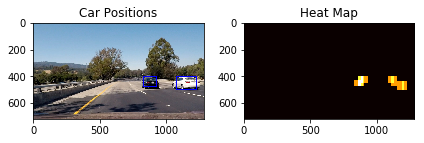

In [8]:
### IMPORT DEPENDENCIES
from scipy.ndimage.measurements import label


### READ-In an EXAMPLE IMAGE and Corresponding BOUNDING BOXES List
### In Order To TEST The FUNCTIONS Below
# Read in The Example Pickle File with bboxes Saved
# Each Item in the "all_bboxes" List will Contain a List of Boxes for One Test Image
box_list = pickle.load(open( "bbox_pickle.p", "rb" ))
# Read-in the Corresponding Image
image = mpimg.imread('./Test_Images/test4.jpg')
heat  = np.zeros_like(image[:,:,0]).astype(np.float)


### FUNCTION To ADD HEAT To A HEATMAP Based On Hot Bounding Boxes
def add_heat(heatmap, bbox_list):
    # Iterate Through List of bboxes
    for box in bbox_list:
        # Add += 1 for All Pixels Inside Each bbox
        # Assuming Each "box" takes the Form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # OUTPUT Of add_heat(): RETURN UPDATED HEATMAP
    return heatmap

### NOTE!:
### In Practice, We want to Integrate a Heat Map Over Several Frames of Video,
### Such That Areas of Multiple Detections Get "hot", While Transient False Positives Stay "cool".
### We can Then simply Threshold our HeatMap to Remove False Positives.

### FUNCTION To APPLY THRESHOLD To A HEATMAP
def apply_threshold(heatmap, threshold):
    # Zero-out Pixels Below the Threshold
    heatmap[heatmap <= threshold] = 0
    
    # OUTPUT Of apply_threshold(): RETURN THRESHOLDED HEATMAP
    return heatmap


### FUNCTION To DRAW LABELED BOUNDING BOXES
def draw_labeled_bboxes(img, labels):
    # Iterate Through All Detected Cars
    for car_number in range(1, labels[1]+1):
        # Find Pixels With Each car_number Label Value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y Values of Those Pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a Bounding Box Based On min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the Box On the Image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # OUTPUT Of draw_labeled_bboxes(): RETURN The IMAGE With LABELED BOUNDING BOXES DRAWN
    return img


### CALL FUNCTIONS add_heat(), apply_threshold(), label() and TEST & VISUALIZE
### Add Heat to Each Box in Box List
heat = add_heat(heat, box_list)
### Apply Threshold To help Remove False Positives
heat = apply_threshold(heat, 2)
### Prepare To Visualize the Heatmap
heatmap = np.clip(heat, 0, 255)
### Find Final Boxes From Heatmap Using Label Function
labels = label(heatmap)
#print(labels[1], 'Cars Found')
#plt.imshow(labels[0], cmap='gray')
### VISUALIZATION
draw_img = draw_labeled_bboxes(np.copy(image), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()


### Search Method 2: HOG Sub-Sampling Window Search

MODEL PARAMETERS USED:
HOG orientations   :  9
HOG pix_per_cell   :  8
HOG cells_per_block:  2
HOG Channel        :  ALL
spatial_size       :  (32, 32)
hist_bins          :  32

Number Of Windows Searched:  441
1.93  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
1.59  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
2.2  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
2.63  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
1.33  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
1.8  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
1.29  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!
Number Of Windows Searched:  450
1.54  Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1

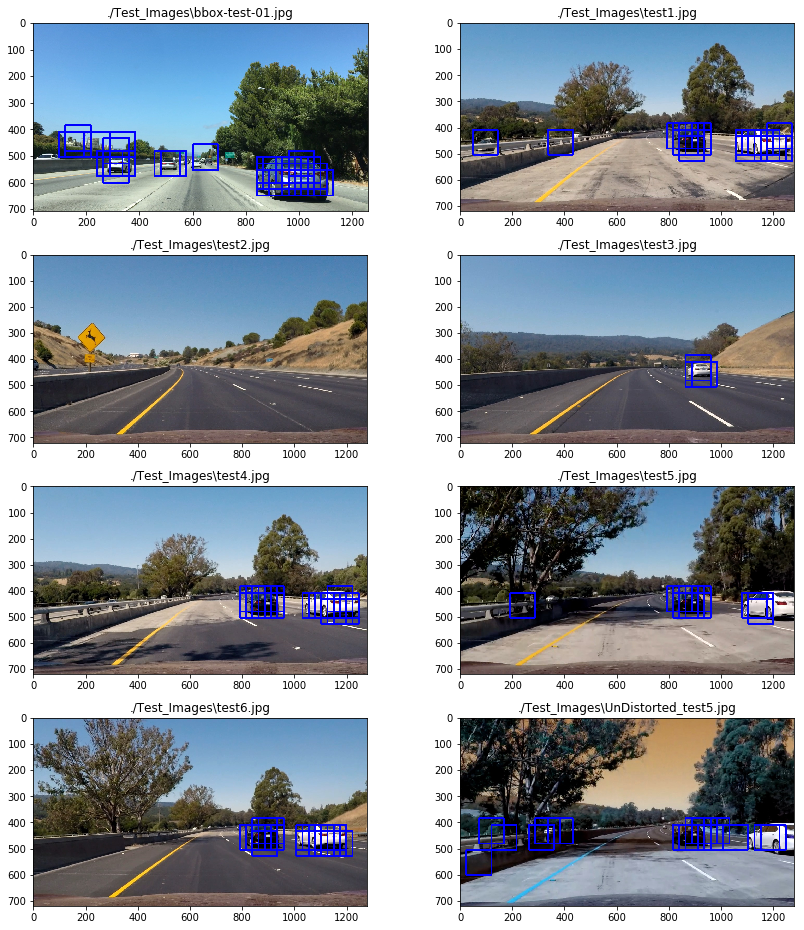

In [9]:
### READ AND LOAD THE TRAINED MODEL & PARAMETERS
model_pickle = pickle.load(open("./model_pickle.p", "rb"))
svc                 = model_pickle["model_classifier_svc"]       # MODEL SVM--LinearSVC.
X_scaler            = model_pickle["model_scaler"]               # MODEL Scaler.
color_space         = model_pickle["param_color_space"]          # COLOR SPACE.
spatial_size        = model_pickle["param_spatial_size"]         # SPATIAL BINNING Dimensions.
hist_bins           = model_pickle["param_hist_bins"]            # COLOR HISTOGRAM Bins.
orientations        = model_pickle["param_hog_orientations"]     # HOG Orientations.
pix_per_cell        = model_pickle["param_hog_pix_per_cell"]     # HOG Pixels Per Cell.
cells_per_block     = model_pickle["param_hog_cells_per_block"]  # HOG Cells Per Block.
hog_channel         = model_pickle["param_hog_channel"]          # HOG Channel.
features_spatial    = model_pickle["param_features_spatial"]     # SPATIAL BINNING Features ON/OFF.
features_color_hist = model_pickle["param_features_color_hist"]  # COLOR HISTOGRAM Features ON/OFF.
features_hog        = model_pickle["param_features_hog"]         # HOG             Features ON/OFF.

### Print the Attributes For Reference
print("MODEL PARAMETERS USED:")
print('HOG orientations   : ', orientations)
print('HOG pix_per_cell   : ', pix_per_cell)
print('HOG cells_per_block: ', cells_per_block)
print('HOG Channel        : ', hog_channel)
print('spatial_size       : ', spatial_size)
print('hist_bins          : ', hist_bins)
print()


### FUNCTION To Do COLOR SPACE CONVERSION
def convert_color(image, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        image_out = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2HLS':
        image_out = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2LUV':
        image_out = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2YUV':
        image_out = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif conv == 'RGB2YCrCb':
        image_out = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        image_out = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # OUTPUT Of convert_color()
    return image_out


### SINGLE FUNCTION That Can BOTH EXTRACT FEATURES & MAKE PREDICTIONS (FIND CARS)
### Using (Primarily) HOG Sub-Sampling
def find_cars(image, ystart, ystop, scale, svc, X_scaler, 
              orientations, pix_per_cell, cells_per_block, spatial_size, hist_bins, 
              cells_per_step=2):
    draw_img = np.copy(image)
    ### !!!NOTE!!!:
    ### Uncomment the Following Line If Training Data Was Extracted From .png Images (Scaled: 0 to 1 by mpimg)
    ### And The Search Image is a .jpg (Scaled: 0 to 255)
    img      = image.astype(np.float32)/255
    
    img_tosearch    = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # BLOCKS To Step in WHOLE IMAGE - Define Blocks and Steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cells_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cells_per_block + 1
    nfeat_per_block = orientations*cells_per_block**2

    # BLOCKS To Step in ONE WINDOW - 64 was the Orginal Sampling Rate, With 8 Cells and 8 Pix Per Cell
    ### NOTE!: We Need To Use For TEST DATA the SAME DIMENSIONS As TRAINING DATA
    ###        In Order that the MODEL's PREDICTION Works CORRECT!
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cells_per_block + 1
    # STEPS in WHOLE IMAGE
    #cells_per_step = 2 # Instead of Overlap, Define How Many Cells To Step.
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute Individual Channel HOG FEATURES For the ENTIRE IMAGE [ORIGINAL IMAGE's ROI] In One Go!
    hog1 = get_hog_features(ch1, orientations, pix_per_cell, cells_per_block, feature_vector=False)
    hog2 = get_hog_features(ch2, orientations, pix_per_cell, cells_per_block, feature_vector=False)
    hog3 = get_hog_features(ch3, orientations, pix_per_cell, cells_per_block, feature_vector=False)
    
    bounding_boxes = [] # List To Store BOUNDING BOXES OF DETECTIONS & RETURN.
    Num_Windows = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            Num_Windows += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG FEATURES For This Patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Extract the Image Patch
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get COLOR FEATURES For This Patch
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features    = color_hist(subimg, nbins=hist_bins)

            ### Scale Features and DO PREDICTION
            test_features   = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw  = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), 
                              (xbox_left+win_draw, ytop_draw+ystart+win_draw),(0,0,255),6)
                bounding_boxes.append( ((xbox_left, ytop_draw+ystart), 
                                        (xbox_left+win_draw, ytop_draw+ystart+win_draw)) )
    
    print("Number Of Windows Searched: ", Num_Windows)
    
    # OUTPUT Of find_cars(): IMAGE With BOUNDING BOX Drawn For CARS FOUND, Also The BOUNDING BOXES
    return draw_img, bounding_boxes


######### CALL FUNCTION find_cars() For Sample TEST IMAGES and Visualize Output #########
### SEARCH WINDOWS PARAMETERS
ystart = 360
ystop  = 656
scale  = 1.5 # Scale 1 => 64x64, Scale 1.5 => 96x96.

### Read-In The Sample Test Images List
test_images_path  = './Test_Images/*'
test_images_files = glob.glob(test_images_path)
test_images_out   = []
images_titles     = []

### FIND CARS In Each Of The Test Image and Visualize Output
for img_file in test_images_files:
    image      = mpimg.imread(img_file)
    t1=time.time()
    image_out, bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orientations, pix_per_cell, cells_per_block, spatial_size, hist_bins)
    t2=time.time()
    print(round(t2-t1, 2), ' Seconds To Do HOG SUB-SAMPLING WINDOWS SEARCH In 1 Test Image...!')
    test_images_out.append(image_out)
    images_titles.append(img_file)

### VISUALIZE
fig = plt.figure(figsize=(12,16))#, dpi=300)
visualize_plot_many(fig, rows=5, columns=2, images=test_images_out, titles=images_titles)


## 4. APPLICATION ON VIDEO STREAM

In [10]:
### IMPORT DEPENDENCIES Needed To Work With Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
### VEHICLE DETECTION & TRACKING PIPELINE #########
### READ AND LOAD THE TRAINED MODEL & PARAMETERS
model_pickle = pickle.load(open("./model_pickle.p", "rb"))
svc                 = model_pickle["model_classifier_svc"]       # MODEL SVM--LinearSVC.
X_scaler            = model_pickle["model_scaler"]               # MODEL Scaler.
color_space         = model_pickle["param_color_space"]          # COLOR SPACE.
spatial_size        = model_pickle["param_spatial_size"]         # SPATIAL BINNING Dimensions.
hist_bins           = model_pickle["param_hist_bins"]            # COLOR HISTOGRAM Bins.
orientations        = model_pickle["param_hog_orientations"]     # HOG Orientations.
pix_per_cell        = model_pickle["param_hog_pix_per_cell"]     # HOG Pixels Per Cell.
cells_per_block     = model_pickle["param_hog_cells_per_block"]  # HOG Cells Per Block.
hog_channel         = model_pickle["param_hog_channel"]          # HOG Channel.
features_spatial    = model_pickle["param_features_spatial"]     # SPATIAL BINNING Features ON/OFF.
features_color_hist = model_pickle["param_features_color_hist"]  # COLOR HISTOGRAM Features ON/OFF.
features_hog        = model_pickle["param_features_hog"]         # HOG             Features ON/OFF.

### Define a CLASS `VehiclesTrack` To Receive & Store the Characteristics Of Vehicles Detection in Each Frame
class VehiclesTrack():
    def __init__(self):
        # Keep a Count of the Frame Number
        self.FrameNumber    =  0
        # Number Of Last `nFrames` In Which To Track Vehicles [i.e, To Track Bounding Boxes]
        self.nFramesToTrack = 30
        # List Of Number Of Bounding Boxes In Each Of Last `nFrames`
        self.LastnFrames_nBBoxesAppendsPerFrame = []
        # List Of Bounding Boxes In Last `nFrames`
        self.LastnFrames_BBoxes = []
        # HeatMap Of Vehicles Detection In Last `nFrames`
        self.HeatMap       = []
        # Threshold For HeatMap For +Ve Vehicles Detection
        self.HeatThreshold = 112

### Create an INSTANCE Of CLASS `VehiclesTrack` To Track Cars
CarsTrack = VehiclesTrack()


### SEARCH WINDOWS AREAS & PARAMETERS
### Scale: 1 => 64x64, 1.5 => 96x96, 2 => 128x128.
search_area_list = [
    #[(ystart, ystop), scale, cells_per_step]
    [ (360,    520),   1,     1],
    [ (440,    656),   1.5,   2],
    [ (360,    656),   2,     2]
]

######### CARS DETECTION & TRACKING PIPELINE #########
def Pipeline_CarsDetTrack(image):
    CarsTrack.FrameNumber += 1
    draw_img = np.copy(image)

    ######### find_cars() In the Current Frame #########
    nBBoxesAppendsPerFrame = 0 ### <-- THIS EQUALS NUMBER OF TIMES We CALL find_cars() And `.append(bboxes)`!
    
    for search_area in search_area_list:
        image_out, bboxes = find_cars(image, 
                                      search_area[0][0], search_area[0][1], 
                                      search_area[1], 
                                      svc, X_scaler, 
                                      orientations, pix_per_cell, cells_per_block, 
                                      spatial_size, hist_bins, 
                                      search_area[2])
        CarsTrack.LastnFrames_BBoxes.append(bboxes)
        #len_bboxes = len(bboxes)
        #if (len_bboxes == 0):
        #    nBBoxesAppendsPerFrame += 1 # To Count Even Empty Appends - And Remove Properly During Management Later!!!
        #else:
        #    nBBoxesAppendsPerFrame += len_bboxes
        ### !!!NOTE!!!: THE ABOVE CODE BLOCK LEADS TO ERROR                                     ###
        ### Later In "PIPELINE MANAGEMENT" Below, During `bboxes` Pop@Head!!!                   ###
        ### IMMATERIAL OF NUMBER OF `bboxes`, THE APPEND IS ALWAYS ONLY 1                       ###
        ### AND THE NUMBER OF APPENDS IS WHAT IS REMOVED, NOT THE INDIVIDUAL ELEMENTS INSIDE!!! ###
        ### E.g.: For `bboxes` = 0,1,2,... (NOTE THE '[' & ']'):                                ###
        ### [], [(x1,y1),(x2,y2)], [((x1,y1),(x2,y2)), ((x3,y3),(x4,y4))], ...                  ###
        ### BUG FIX: SO WE JUST COUNT THE 1 APPEND!!!:                                          ###
        nBBoxesAppendsPerFrame += 1
        
        ### FOR DEBUG ###
        ### print()
        ### print("Frame: ",CarsTrack.FrameNumber,", Details For BBoxes Found in Scale'n':")
        ### print("Number Of BBoxes: ",len(bboxes))
        ### print("nBBoxesAppendsPerFrame: ",nBBoxesAppendsPerFrame)
        ### print("bboxes:")
        ### print(bboxes)
        ### print("CarsTrack.LastnFrames_BBoxes:")
        ### print(CarsTrack.LastnFrames_BBoxes)
        ### print()
    
    CarsTrack.LastnFrames_nBBoxesAppendsPerFrame.append(nBBoxesAppendsPerFrame)
    ### FOR DEBUG ###
    ### print()
    ### print("CarsTrack.LastnFrames_nBBoxesAppendsPerFrame: ",CarsTrack.LastnFrames_nBBoxesAppendsPerFrame)
    ### print()

    ######### VEHICLES DETECTION MANAGEMENT In Each Frame #########
    #if ( (CarsTrack.FrameNumber > CarsTrack.nFramesToTrack) & ((CarsTrack.FrameNumber % CarsTrack.nFramesToTrack) == 1) ):
    if (CarsTrack.FrameNumber > CarsTrack.nFramesToTrack):
        ### DETECT VALID VEHICLES
        CarsTrack.HeatMap = np.zeros_like(image[:,:,0]).astype(np.float)
        for Frame_BBoxes in CarsTrack.LastnFrames_BBoxes:
            CarsTrack.HeatMap = add_heat(CarsTrack.HeatMap, Frame_BBoxes)
        CarsTrack.HeatMap = apply_threshold(CarsTrack.HeatMap, CarsTrack.HeatThreshold)
        #CarsTrack.HeatMap = np.clip(CarsTrack.HeatMap, 0, 255)
        labels   = label(CarsTrack.HeatMap)
        
        ### DRAW BOUNDING BOXES OF DETECTED VEHICLES
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        ### VEHICLES DETECTION PIPELINE MANAGEMENT
        #PastBBoxesToDrop = 0
        #for i in range CarsTrack.nFramesToTrack:
        #    PastBBoxesToDrop += CarsTrack.LastnFrames_nBBoxesAppendsPerFrame[i]
        PastBBoxesToDrop = CarsTrack.LastnFrames_nBBoxesAppendsPerFrame[0]
        CarsTrack.LastnFrames_BBoxes = CarsTrack.LastnFrames_BBoxes[PastBBoxesToDrop:]
        #CarsTrack.LastnFrames_nBBoxesAppendsPerFrame = CarsTrack.LastnFrames_nBBoxesAppendsPerFrame[CarsTrack.nFramesToTrack:]
        CarsTrack.LastnFrames_nBBoxesAppendsPerFrame = CarsTrack.LastnFrames_nBBoxesAppendsPerFrame[1:]
        ### FOR DEBUG ###
        ### print("Frame: ",CarsTrack.FrameNumber,", AFTER MANAGEMENT:")
        ### print("PastBBoxesToDrop: ",PastBBoxesToDrop)
        ### print("CarsTrack.LastnFrames_BBoxes:")
        ### print(CarsTrack.LastnFrames_BBoxes)
        ### print("CarsTrack.LastnFrames_nBBoxesAppendsPerFrame:")
        ### print(CarsTrack.LastnFrames_nBBoxesAppendsPerFrame)

    ### OUTPUT Of Pipeline_CarsDetTrack(): INPUT IMAGE + DETECTED CARS' Bounding Boxes Drawn
    return draw_img


In [12]:
# WRAPPER FUNCTION For 2 PIPELINES: ADV. LANE FINDING & VEHICLES DETECTION,TRACK ###
def process_image(image_in):
    result2 = Pipeline_CarsDetTrack(image_in)
    return result2


In [13]:
### DETECT VEHICLES In PROJECT INPUT VIDEO './Test_Videos/project_video.mp4'
output_video_4 = './Output_Videos/Project_Video_Output_VehDet.mp4'
# NOTE!:
# To Speed-up the Testing Process,
# We may want to Try The Pipeline on a Shorter SubClip of the Video.
# To Do So, Add `.subclip(start_second,end_second)` To the End Of the Line Below,
# (`start_second` and `end_second` are Integer Values,
#  Representing the Start and End of the SubClip).
# For E.g., We may UnComment the Following Line For a SubClip of the First 5 Seconds:
#clip4 = VideoFileClip("./Test_Videos/project_video.mp4").subclip(0,5)
clip4 = VideoFileClip("./Test_Videos/project_video.mp4").subclip(0,1)
pipeline_output = clip4.fl_image(process_image)
%time pipeline_output.write_videofile(output_video_4, audio=False)


Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222
[MoviePy] >>>> Building video ./Output_Videos/Project_Video_Output_VehDet.mp4
[MoviePy] Writing video ./Output_Videos/Project_Video_Output_VehDet.mp4


  0%|                                                   | 0/26 [00:00<?, ?it/s]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


  4%|█▋                                         | 1/26 [00:09<03:56,  9.48s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


  8%|███▎                                       | 2/26 [00:19<03:54,  9.77s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 12%|████▉                                      | 3/26 [00:31<03:55, 10.25s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 15%|██████▌                                    | 4/26 [00:38<03:25,  9.35s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 19%|████████▎                                  | 5/26 [00:46<03:06,  8.88s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 23%|█████████▉                                 | 6/26 [00:54<02:55,  8.80s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 27%|███████████▌                               | 7/26 [01:02<02:41,  8.49s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 31%|█████████████▏                             | 8/26 [01:09<02:25,  8.09s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 35%|██████████████▉                            | 9/26 [01:15<02:06,  7.42s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 38%|████████████████▏                         | 10/26 [01:22<01:56,  7.30s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 42%|█████████████████▊                        | 11/26 [01:28<01:43,  6.88s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 46%|███████████████████▍                      | 12/26 [01:35<01:37,  6.94s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 50%|█████████████████████                     | 13/26 [01:42<01:27,  6.76s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 54%|██████████████████████▌                   | 14/26 [01:48<01:21,  6.81s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 58%|████████████████████████▏                 | 15/26 [01:56<01:18,  7.09s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 62%|█████████████████████████▊                | 16/26 [02:03<01:08,  6.89s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 65%|███████████████████████████▍              | 17/26 [02:09<01:00,  6.71s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 69%|█████████████████████████████             | 18/26 [02:16<00:53,  6.67s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 73%|██████████████████████████████▋           | 19/26 [02:25<00:53,  7.65s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 77%|████████████████████████████████▎         | 20/26 [02:32<00:43,  7.31s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 81%|█████████████████████████████████▉        | 21/26 [02:38<00:35,  7.05s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 85%|███████████████████████████████████▌      | 22/26 [02:46<00:28,  7.18s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 88%|█████████████████████████████████████▏    | 23/26 [02:52<00:20,  6.97s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 92%|██████████████████████████████████████▊   | 24/26 [02:58<00:13,  6.71s/it]

Number Of Windows Searched:  1989
Number Of Windows Searched:  300
Number Of Windows Searched:  222


 96%|████████████████████████████████████████▍ | 25/26 [03:06<00:06,  6.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Output_Videos/Project_Video_Output_VehDet.mp4 

Wall time: 3min 8s


In [ ]:
### Open Output Video in Interactive Window Here
### Original Size 1280x720 --> 0.6x --> 768x432
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(output_video_4))


---
---
---